<h1>Micrometeoroid detection on lunar surface via accelerometer data</h1>
<h2>Approach:</h2> Accelerometer data consists of acceleration versus time. Acceleration data is separately recorded
for three directions.As I have observed there is no strong correlation between the data of three components.So I'll proceed with finding maximas in one stream of data.To separate micrometeoroid impact part in the signal, we'll have to decide some threshold amplitude. If the amplitude of signal exceeds the threshold we'll store the time and amplitude of signal at that point in a different list.(This is done using indices).Using these indices we can separate the part for Human analyses which can be filtered further and sent for detection of p and s waves, till now what I have read In most earthquakes Pwave is smaller and weaker whaereas in impact phenomenon s waves are weaker.

In [1]:
'''Importing libraries for functionalities'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt,find_peaks

For now as I don't have data streams with  multiple quakes , I will be using data generated by myshake app to demonstate separation od seismic wave from region of interest.

In [2]:
datafile=pd.read_csv('micromet.csv')#reading file
datafile.fillna(0)#replacing nan values by zero.
datafile.describe()

Time           X           Y           Z
count  9.530000e+02  953.000000  953.000000  953.000000
mean   1.585823e+12    0.056054    0.304192    0.947703
std    1.728521e+04    0.048391    0.031120    0.151420
min    1.585823e+12   -0.107280    0.192129    0.471058
25%    1.585823e+12    0.037060    0.288681    0.913832
50%    1.585823e+12    0.062418    0.298434    0.949918
75%    1.585823e+12    0.072170    0.315014    0.983077
max    1.585823e+12    0.241868    0.401813    1.521428

In [3]:
#As the generated data is primarily in Z component so we'll be using Z axis to demostrate separation of relevant seismic wave.
data=datafile.iloc[:,3]
#De-meaning the data,correcting for offset by subtraction of mean of data from all elements 
data=data-np.ones_like(data)*np.mean(data)


In [4]:
butter_filter=butter(N=2,Wn=0.01,btype='highpass',analog=False,output='ba')#Lowermost measurable frequency
#setting critical frequency =0.01 of 
data_Filt1=np.sqrt(8/3)*filtfilt(butter_filter[0],butter_filter[1],data)#applying filter on data, data_Filt1=dat ifltered by first filter
t=np.linspace(0,50,953)#from time 0 to 50 s 953 readings were taken

There are two approaches of picking a seismic wave from a stream of signal,first is to detect an amplitude fluctuation and then pick up a fixed number of values from data stream before and after this fluctuation. This has disadvantage as the duration of seismic activity is not known before hand. Another approach is to decide some threshold amplitude and cut signal from wherever this threshold is met, in this also we kind of fix minimum duration of seismic wave expected.But here the length of seismic wave we can capture is not predefined and would be adjusted on it's own. 

In [5]:
def return_mult(data):
    '''This function returns the value of multiplier to mean in order to set threshold of amplitude. '''
    k=0
    for i in range(100):
        if i*np.mean(abs(data))<=max(abs(data)) and (i+1)*np.mean(abs(data))>max(abs(data)):
            k=i
            break
    return k
return_mult(data_Filt1)

5

Next We'll see whether we are able to select seismic waves or not .This can be done by adjusting the multiplier (example-instead of k use k+1 instead) if it is not working properly.

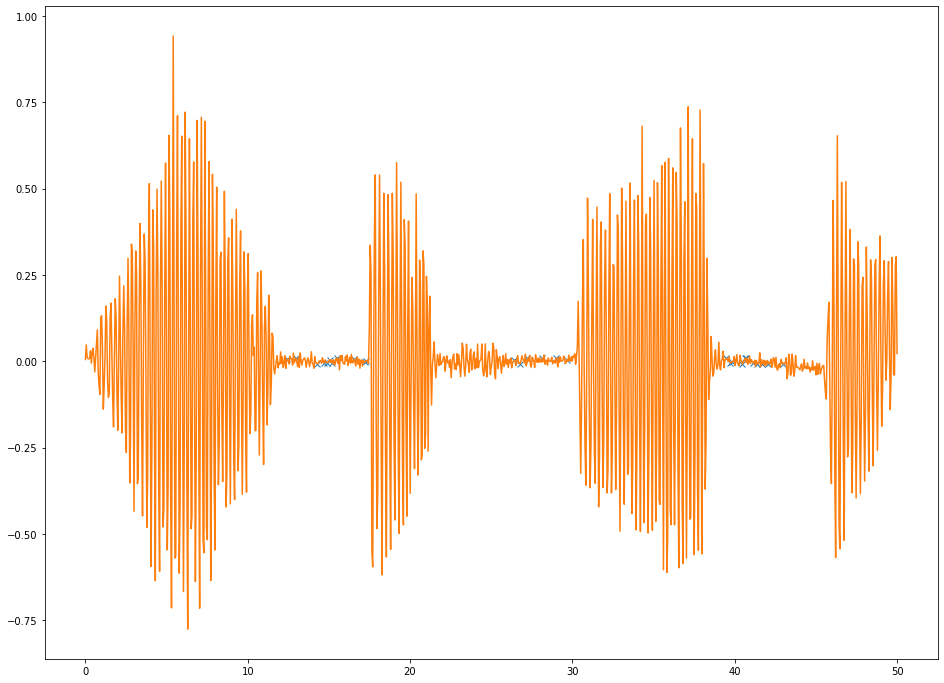

In [6]:
'''Visualising separtion of seismic part from data stream'''

k=return_mult(data_Filt1)
#storing locations and heights of the points where amplitude meets the required threshold.
location,heights=find_peaks(abs(data_Filt1),height=(0.001*(k+1)*np.mean(abs(data_Filt1)),0.01*(k+1)*np.mean(abs(data_Filt1))))
plt.figure(figsize=(16,12))
plt.plot(location*50/953,data_Filt1[location],'x')#the blue x visible are the locations selected.
plt.plot(t,data_Filt1)

In [7]:
'''Now to ensure min difference between the parts we need to cut. '''
diff=np.diff(location)  
location

array([237, 247, 272, 280, 284, 287, 290, 295, 315, 328, 330, 503, 510,
       519, 536, 552, 565, 752, 757, 759, 771, 774, 776, 784, 789, 795,
       802, 819], dtype=int64)

In [8]:
a=list()
for i in range(np.size(diff)):
    if diff[i]>=50:
        a.append(i)
a

[10, 16]

In [9]:
'''Storing the separate signals as elements of list'''

Separate_signal=list()
if location[0]!=0:
    Separate_signal.append(data_Filt1[:location[0]])
for i in range(np.size(a)):
    Separate_signal.append(data_Filt1[location[a[i]]:location[a[i]+1]])
if location[-1]!=953:
    Separate_signal.append(data_Filt1[location[-1]:])
np.size(Separate_signal)

4

In [10]:
plt.figure(figsize=(128,96))
for i in range(np.size(Separate_signal)):
    t=np.linspace(0,50/953*np.size(Separate_signal[i]),np.size(Separate_signal[i]))
    plt.subplot(np.size(Separate_signal), 2, 2*i+ 1)
    plt.plot(t,Separate_signal[i],linewidth=5,color='r')
    ffta=np.fft.fft(Separate_signal[i])
    fftfreq=np.fft.fftfreq(np.size(Separate_signal[i]),50/953)
    Power_spectral=(ffta*np.conjugate(ffta))*50
    plt.subplot(np.size(Separate_signal),2,2*(i+1))
    plt.plot(abs(fftfreq),Power_spectral,linewidth=5)

C:\Users\anmol harshana\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Reading the data values for three componenets of elcentro earthquake.
Now that the mechanism for separation is demonstrated We'll proceed to real earthquake data to see how we can see whether it's an impact or a quake. 

In [11]:
datafile1=pd.read_csv('elcentro_EW.dat',sep=' ')
datafile2=pd.read_csv('elcentro_NS.dat',sep=' ')
datafile3=pd.read_csv('elcentro_UP.dat',sep=' ')
butter_filter=butter(N=2,Wn=0.02/25,btype='highpass',analog=False,output='ba')
print('East West component','\n',datafile1.describe(),'\n','\n','North-South component','\n',datafile2.describe(),'\n','\n','Vertical Component','\n',datafile3.describe())

East West component 
               time  acceleration
count  2674.000000   2674.000000
mean     26.730000     -0.000218
std      15.441233      0.039617
min       0.000000     -0.182526
25%      13.365000     -0.013358
50%      26.730000     -0.000102
75%      40.095000      0.011115
max      53.460000      0.214137 
 
 North-South component 
               time  acceleration
count  2688.000000   2688.000000
mean     26.870000      0.000049
std      15.522062      0.046928
min       0.000000     -0.268181
25%      13.435000     -0.012746
50%      26.870000     -0.000306
75%      40.305000      0.010936
max      53.740000      0.348737 
 
 Vertical Component 
               time  acceleration
count  2690.000000   2690.000000
mean     26.890000     -0.000049
std      15.533609      0.024105
min       0.000000     -0.210058
25%      13.445000     -0.004665
50%      26.890000     -0.000102
75%      40.335000      0.004589
max      53.780000      0.193743


In [12]:
a1=datafile1.iloc[0::,1]#acceleration in N-S 
a1=list(a1)
a1=np.array(a1)
a1=a1-np.ones(np.size(a1))*np.mean(a1)#De-meaning data to cancel offset 
a1=list(a1)
for i in range(26):#this step is done to equate size of three datastreams as they were not equal initially.(see count)
    a1.append(0)
a1=np.array(a1)
a1=np.sqrt(8/3)*filtfilt(butter_filter[0],butter_filter[1],a1)

In [13]:
a=datafile2.iloc[0::,1]#acceleration in E-W
a2=list(a)
a2=np.array(a2)
a2=a2-np.ones(np.size(a2))*np.mean(a2)#De-meaning data to cancel offset 
a2=list(a2)
for i in range(12):#this step is done to equate size of three datastreams as they were not equal initially.
    a2.append(0)
a2=np.array(a2)
a2=np.sqrt(8/3)*filtfilt(butter_filter[0],butter_filter[1],a2)

In [14]:
a=datafile3.iloc[0::,1]#acceleration in vertical direction
a3=list(a)
a3=np.array(a3)
a3=a3-np.ones(np.size(a3))*np.mean(a3)#De-meaning data to cancel offset 
a3=list(a3)
for i in range(10):#this step is done to equate size of three datastreams as they were not equal initially.
    a3.append(0)
a3=np.array(a3)
Input=list()
Input.append(a1)
Input.append(a2)
Input.append(a3)
a3=np.sqrt(8/3)*filtfilt(butter_filter[0],butter_filter[1],a3)

In [15]:
#defining a dictionary for directions
Directions={0:'E-W',1:'N-S',2:'UP'}

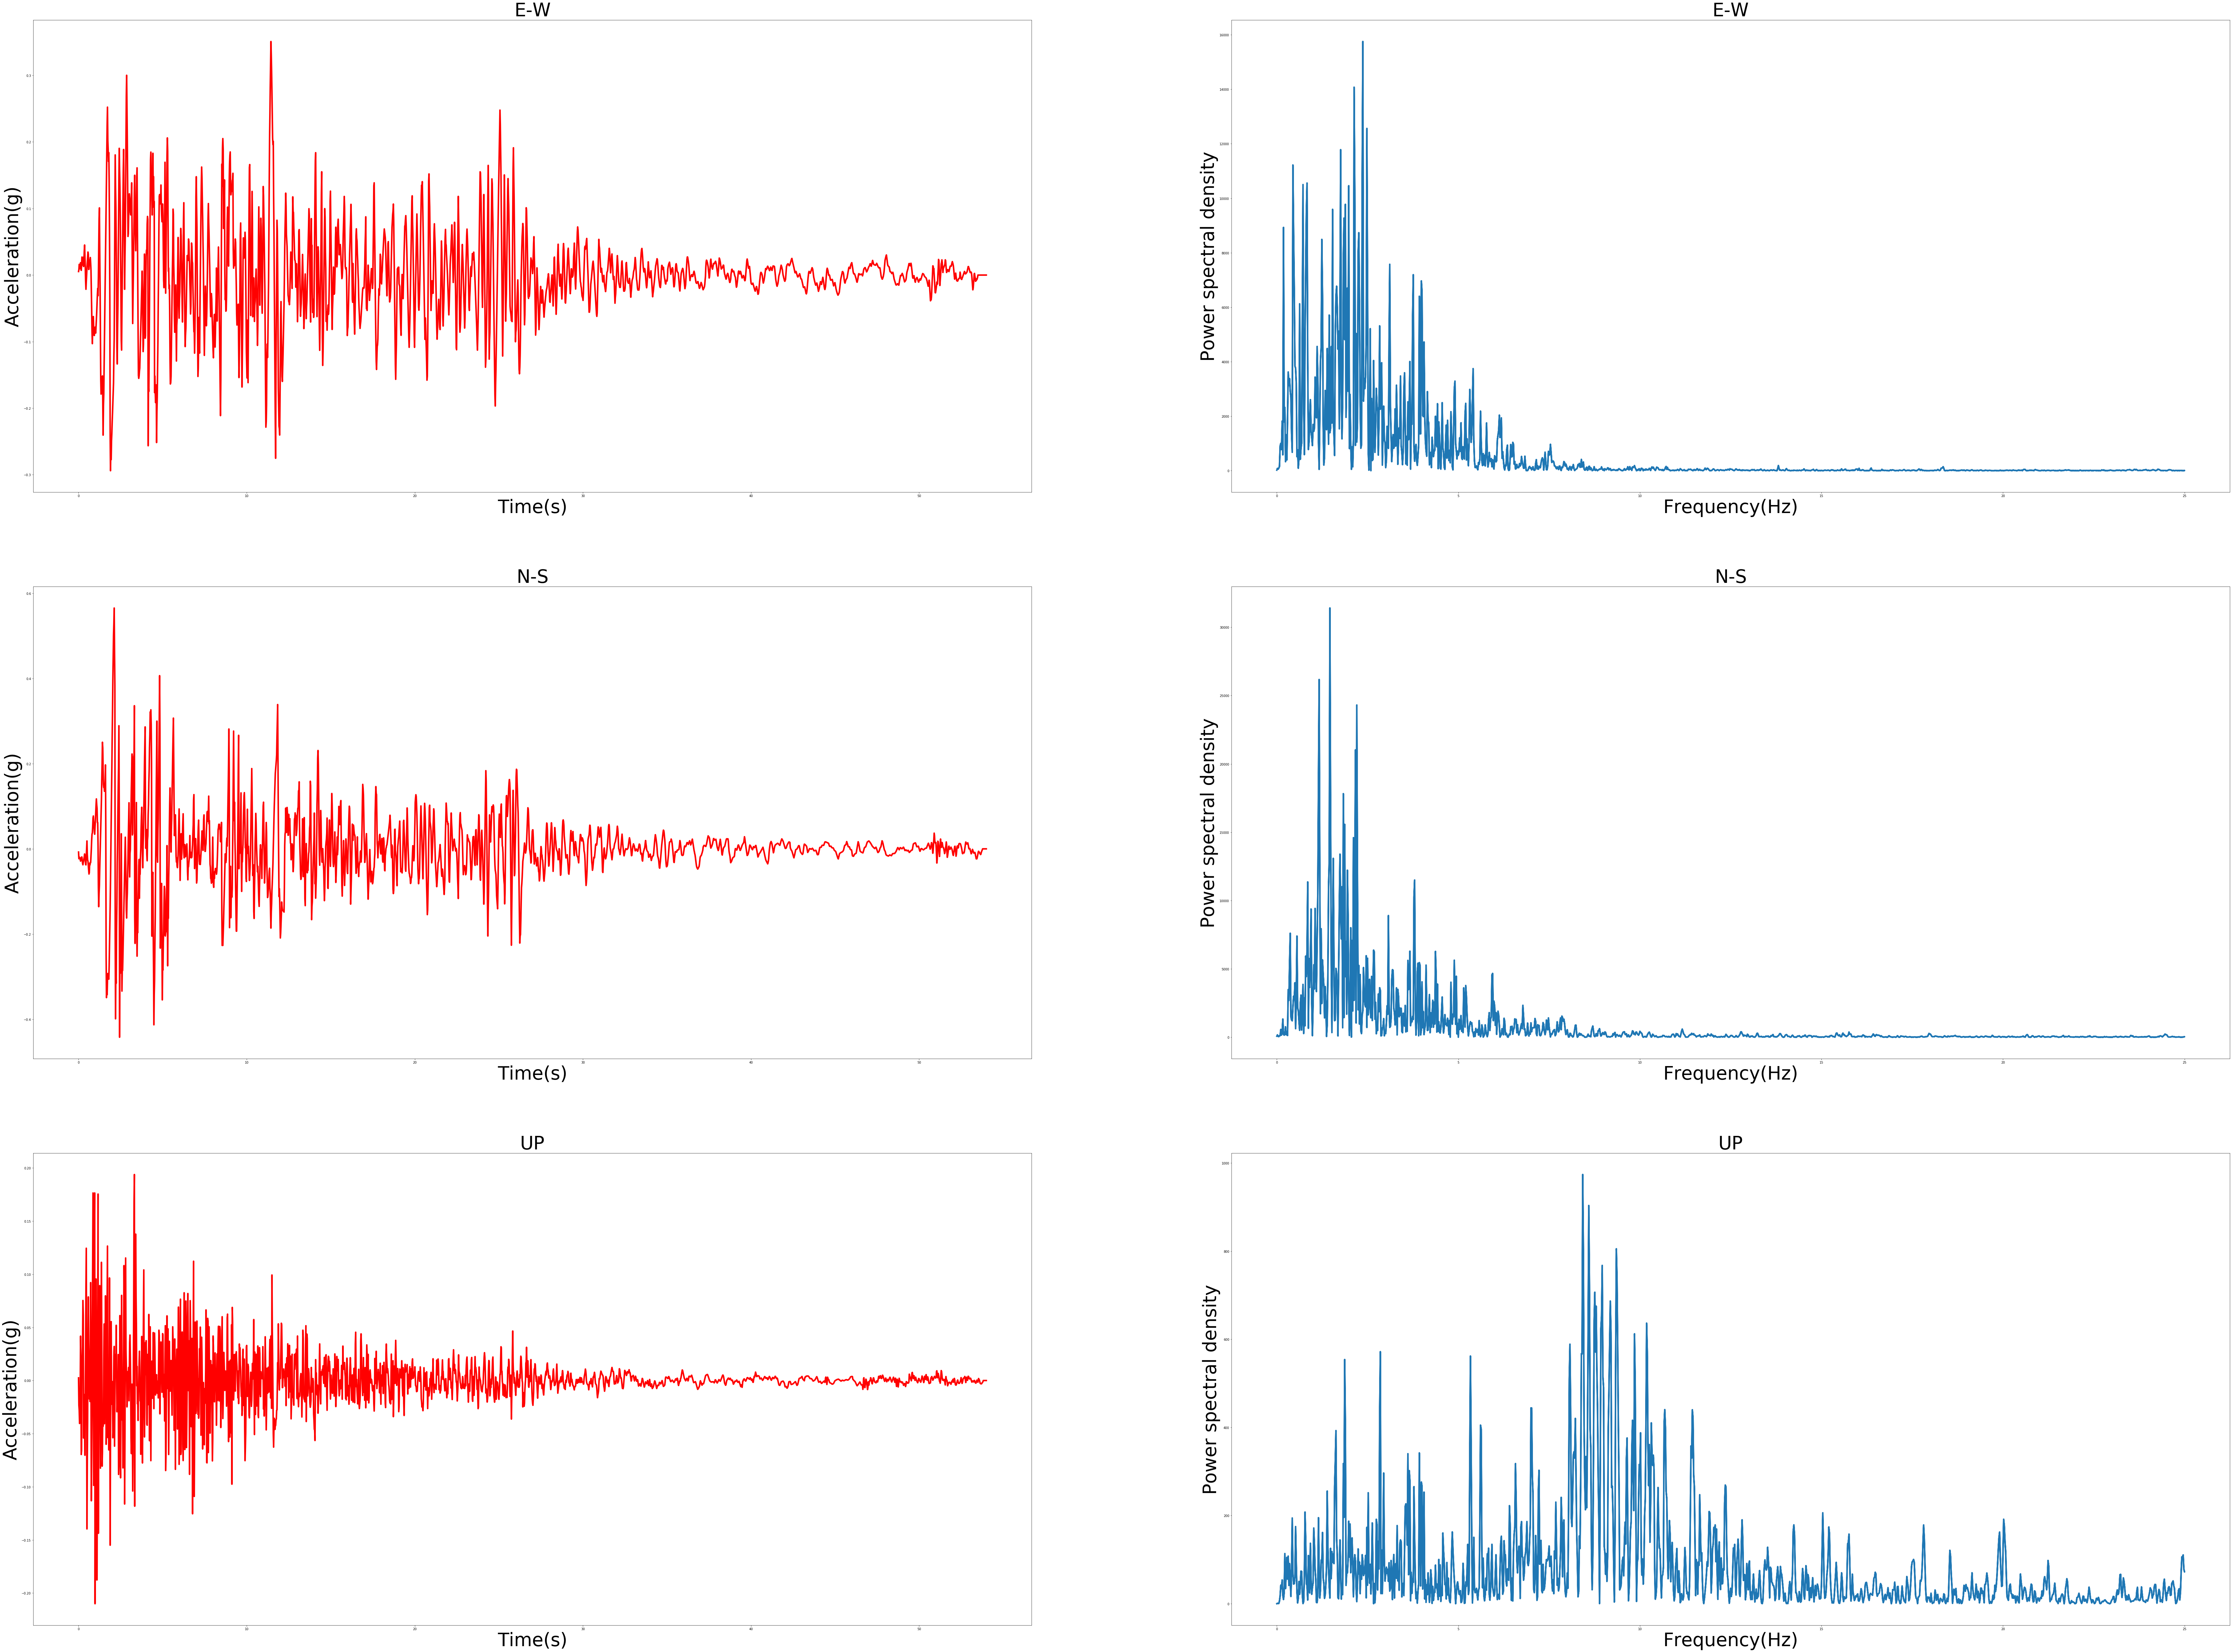

In [16]:
'''Plotting the accleration time and power spectrum of data.'''

plt.figure(figsize=(128,96))
for i in range(int(np.size(Input)/np.size(Input[0]))):
    t=np.linspace(0,54,np.size(Input[i]))
    plt.subplot(np.size(Input)/np.size(Input[0]), 2, 2*i+1)
    plt.plot(t,Input[i],linewidth=5,color='r')
    plt.xlabel('Time(s)',fontsize=60)
    plt.ylabel('Acceleration(g)',fontsize=60)
    plt.title(Directions[i],fontsize=60)
    ffta=np.fft.fft(Input[i])
    fftfreq=np.fft.fftfreq(np.size(Input[i]),0.02)
    Power_spectral=(ffta*np.conjugate(ffta))*54#power spectral density=amplitude^2/delta f where delta f=1/T where T=total time the  signal last
    plt.subplot(np.size(Input)/np.size(Input[i]),2,2*(i+1))
    plt.plot(abs(fftfreq),Power_spectral,linewidth=5)
    plt.xlabel('Frequency(Hz)',fontsize=60)
    plt.title(Directions[i],fontsize=60)
    plt.ylabel('Power spectral density',fontsize=60)

The above graphs show the plots of amplitude of acceleration with time(red) and power spectral density of corresponding graph (blue).It is clear from the graphs that the frequencies dominant in horizontal direction are not so in vertical direction.
This can be due to two reasons :</n>
Reason 1: The waves have different frequency in different directions.</n>
Reason 2: The waves of lower frequency are p waves which are longitudnal and Hence display more effect in horizontal directions ,while the waves of higher frequency are s waves and surface waves.</n>
Assuming reason 2 to be true ,we may be able to predict whether a seismogram is of earthquake or that of an impact phenomenon.

In [17]:
def plot_filtered_seismogram(data,lower_Freq,higher_Freq,Time_lag,order):
    plt.figure(figsize=(64,32))
    butter_filter=butter(order,Wn=(2*lower_Freq*Time_lag,2*higher_Freq*Time_lag),btype='bandpass')
    filtered_data=np.sqrt(8/3)*filtfilt(butter_filter[0],butter_filter[1],data)
    t=np.linspace(0,np.size(data)*Time_lag,np.size(data))
    plt.subplot(1, 2, 1)
    plt.plot(t,filtered_data,linewidth=5,color='r')
    plt.xlabel('Time(s)',fontsize=30)
    plt.ylabel('Acceleration(g)',fontsize=30)
    ffta=np.fft.fft(filtered_data)
    fftfreq=np.fft.fftfreq(np.size(filtered_data),Time_lag)
    Power_spectral=(ffta*np.conjugate(ffta))*54#power spectral density=amplitude^2/delta f where delta f=1/T where T=total time the  signal last
    plt.subplot(1,2,2)
    plt.plot(abs(fftfreq),Power_spectral,linewidth=5)
    plt.xlabel('Frequency(Hz)',fontsize=30)
    plt.ylabel('Power spectral density',fontsize=30)

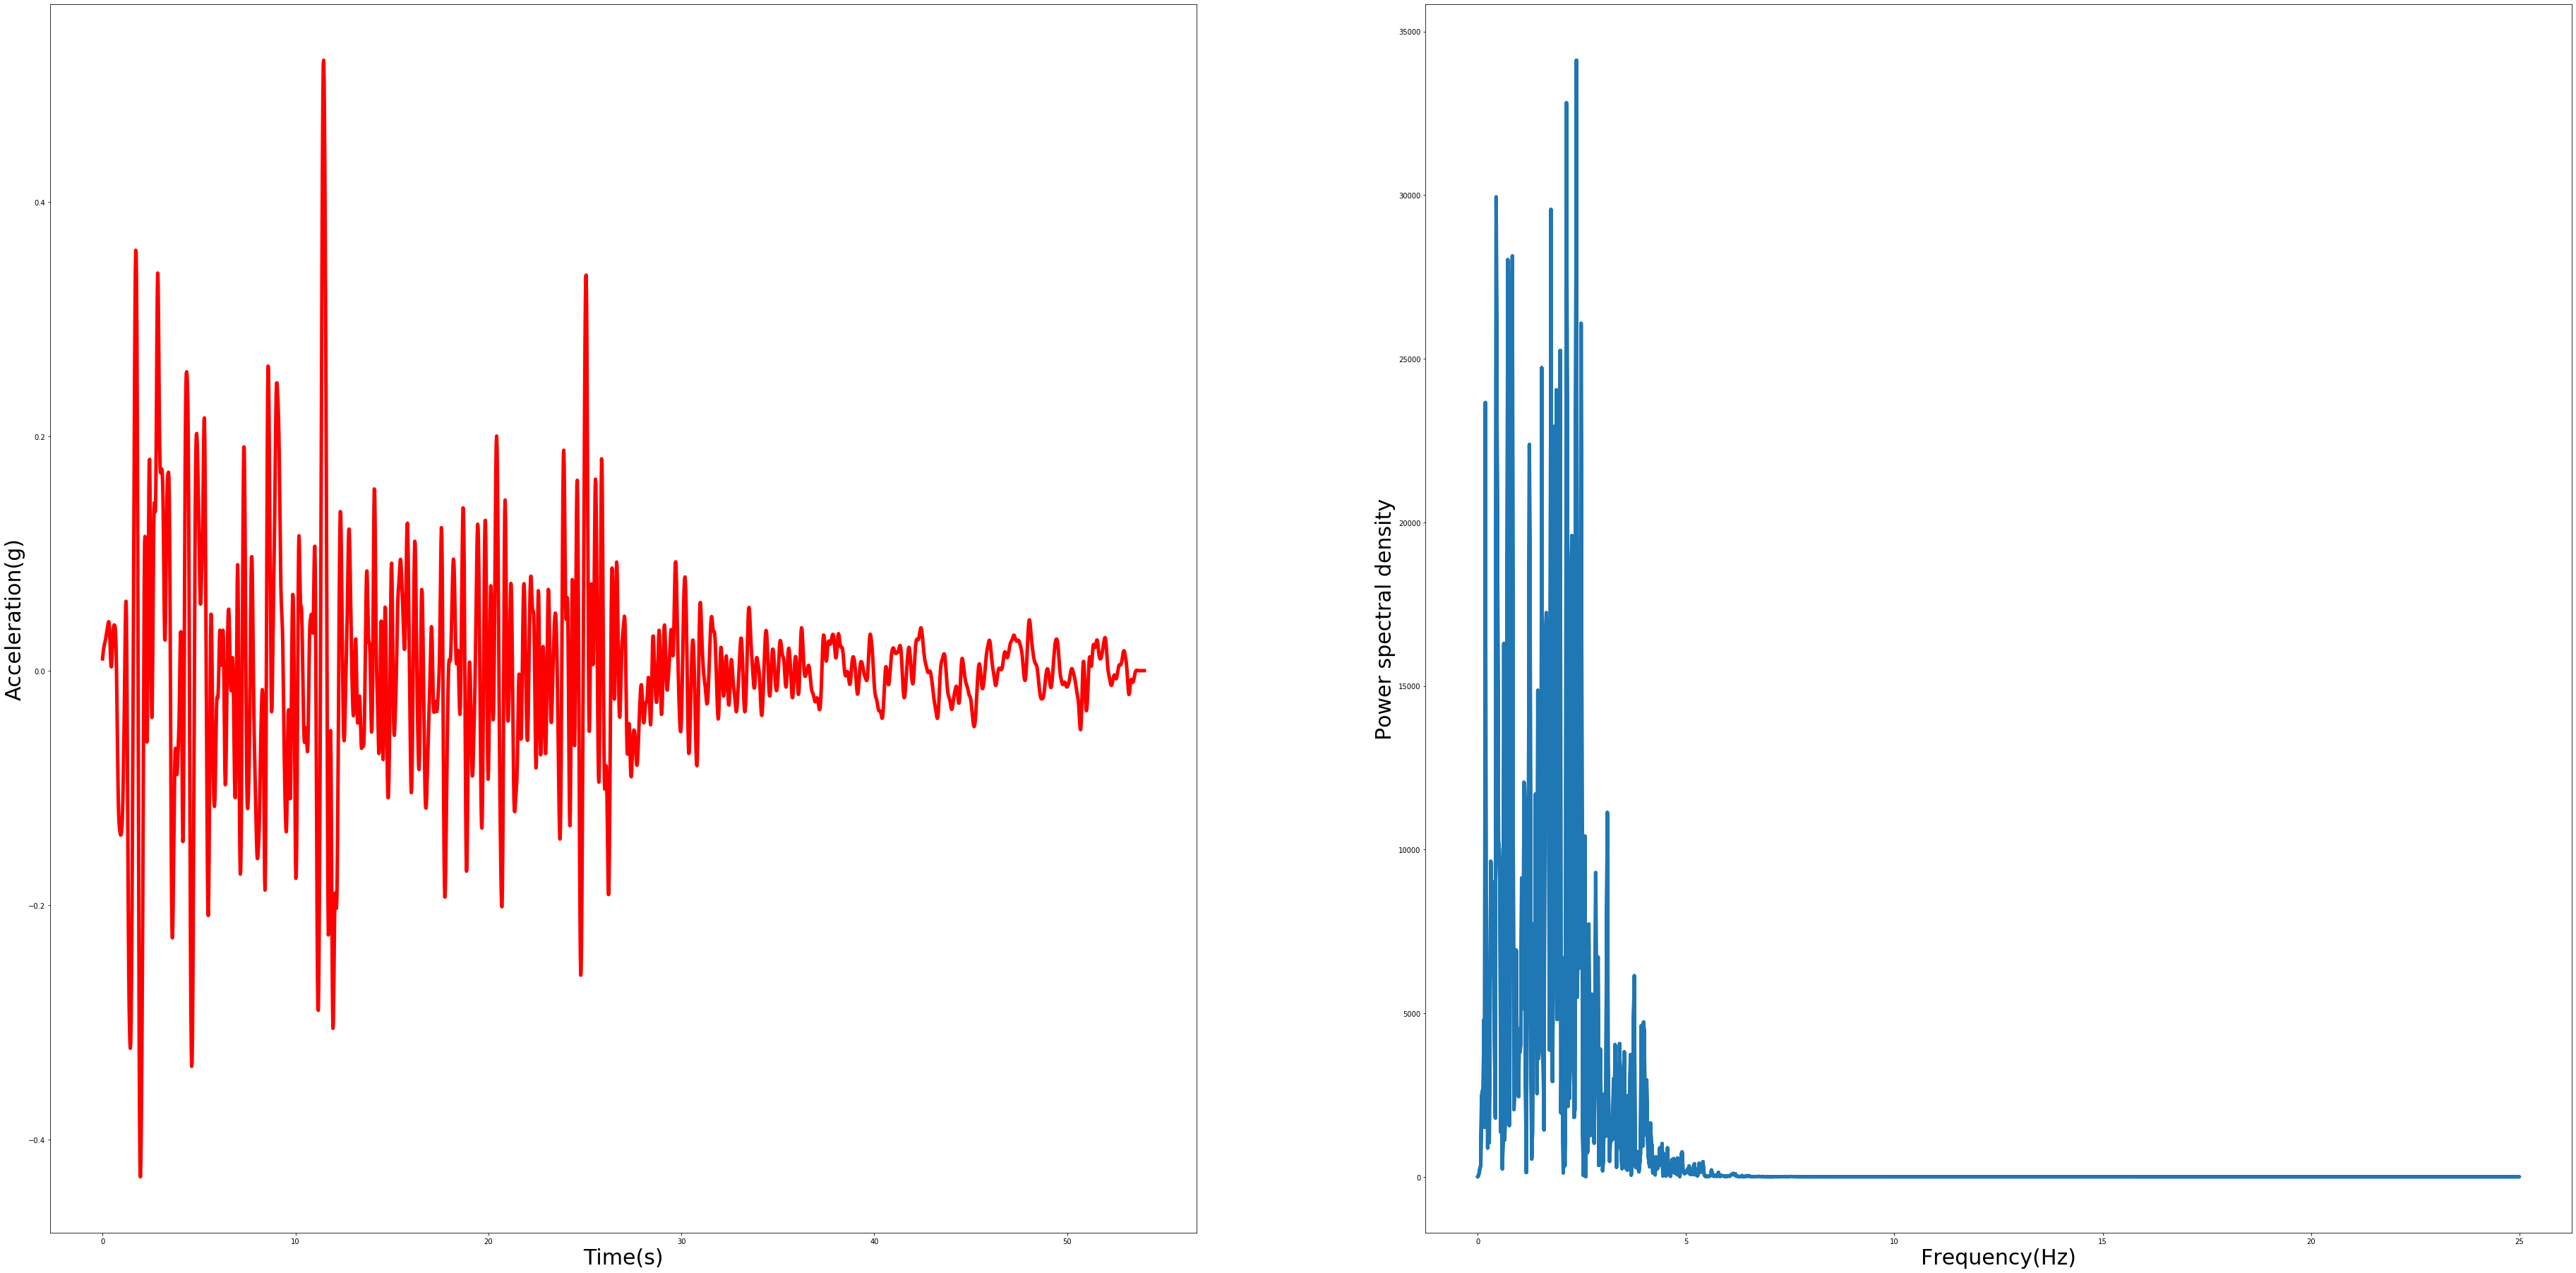

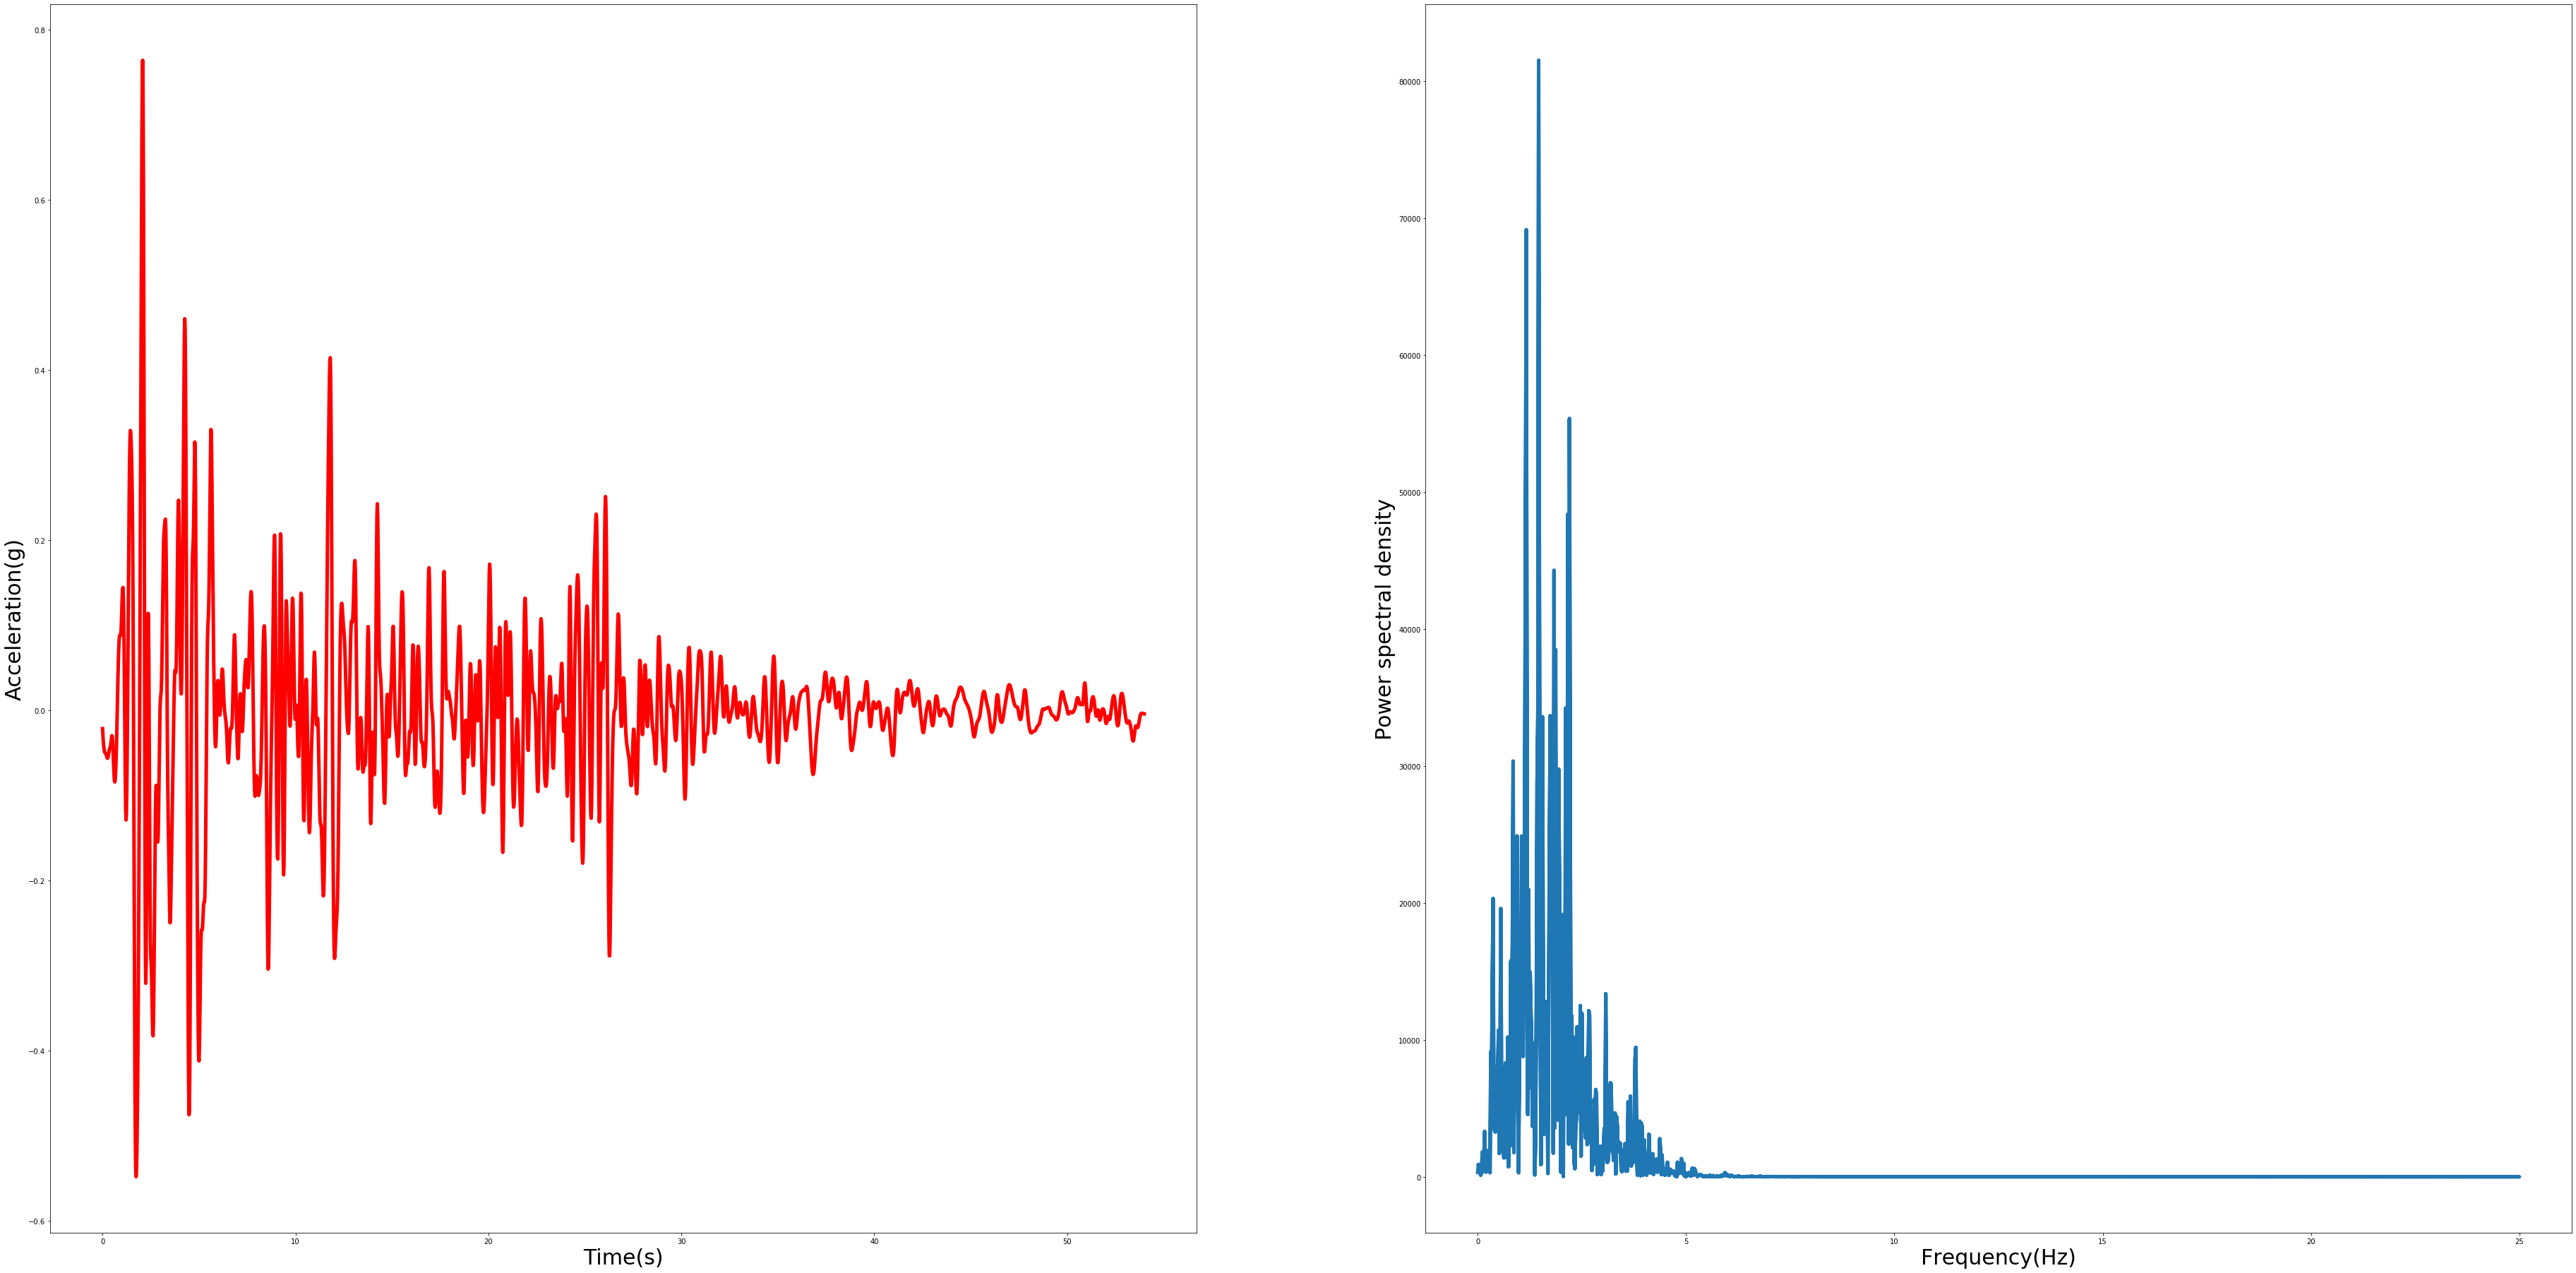

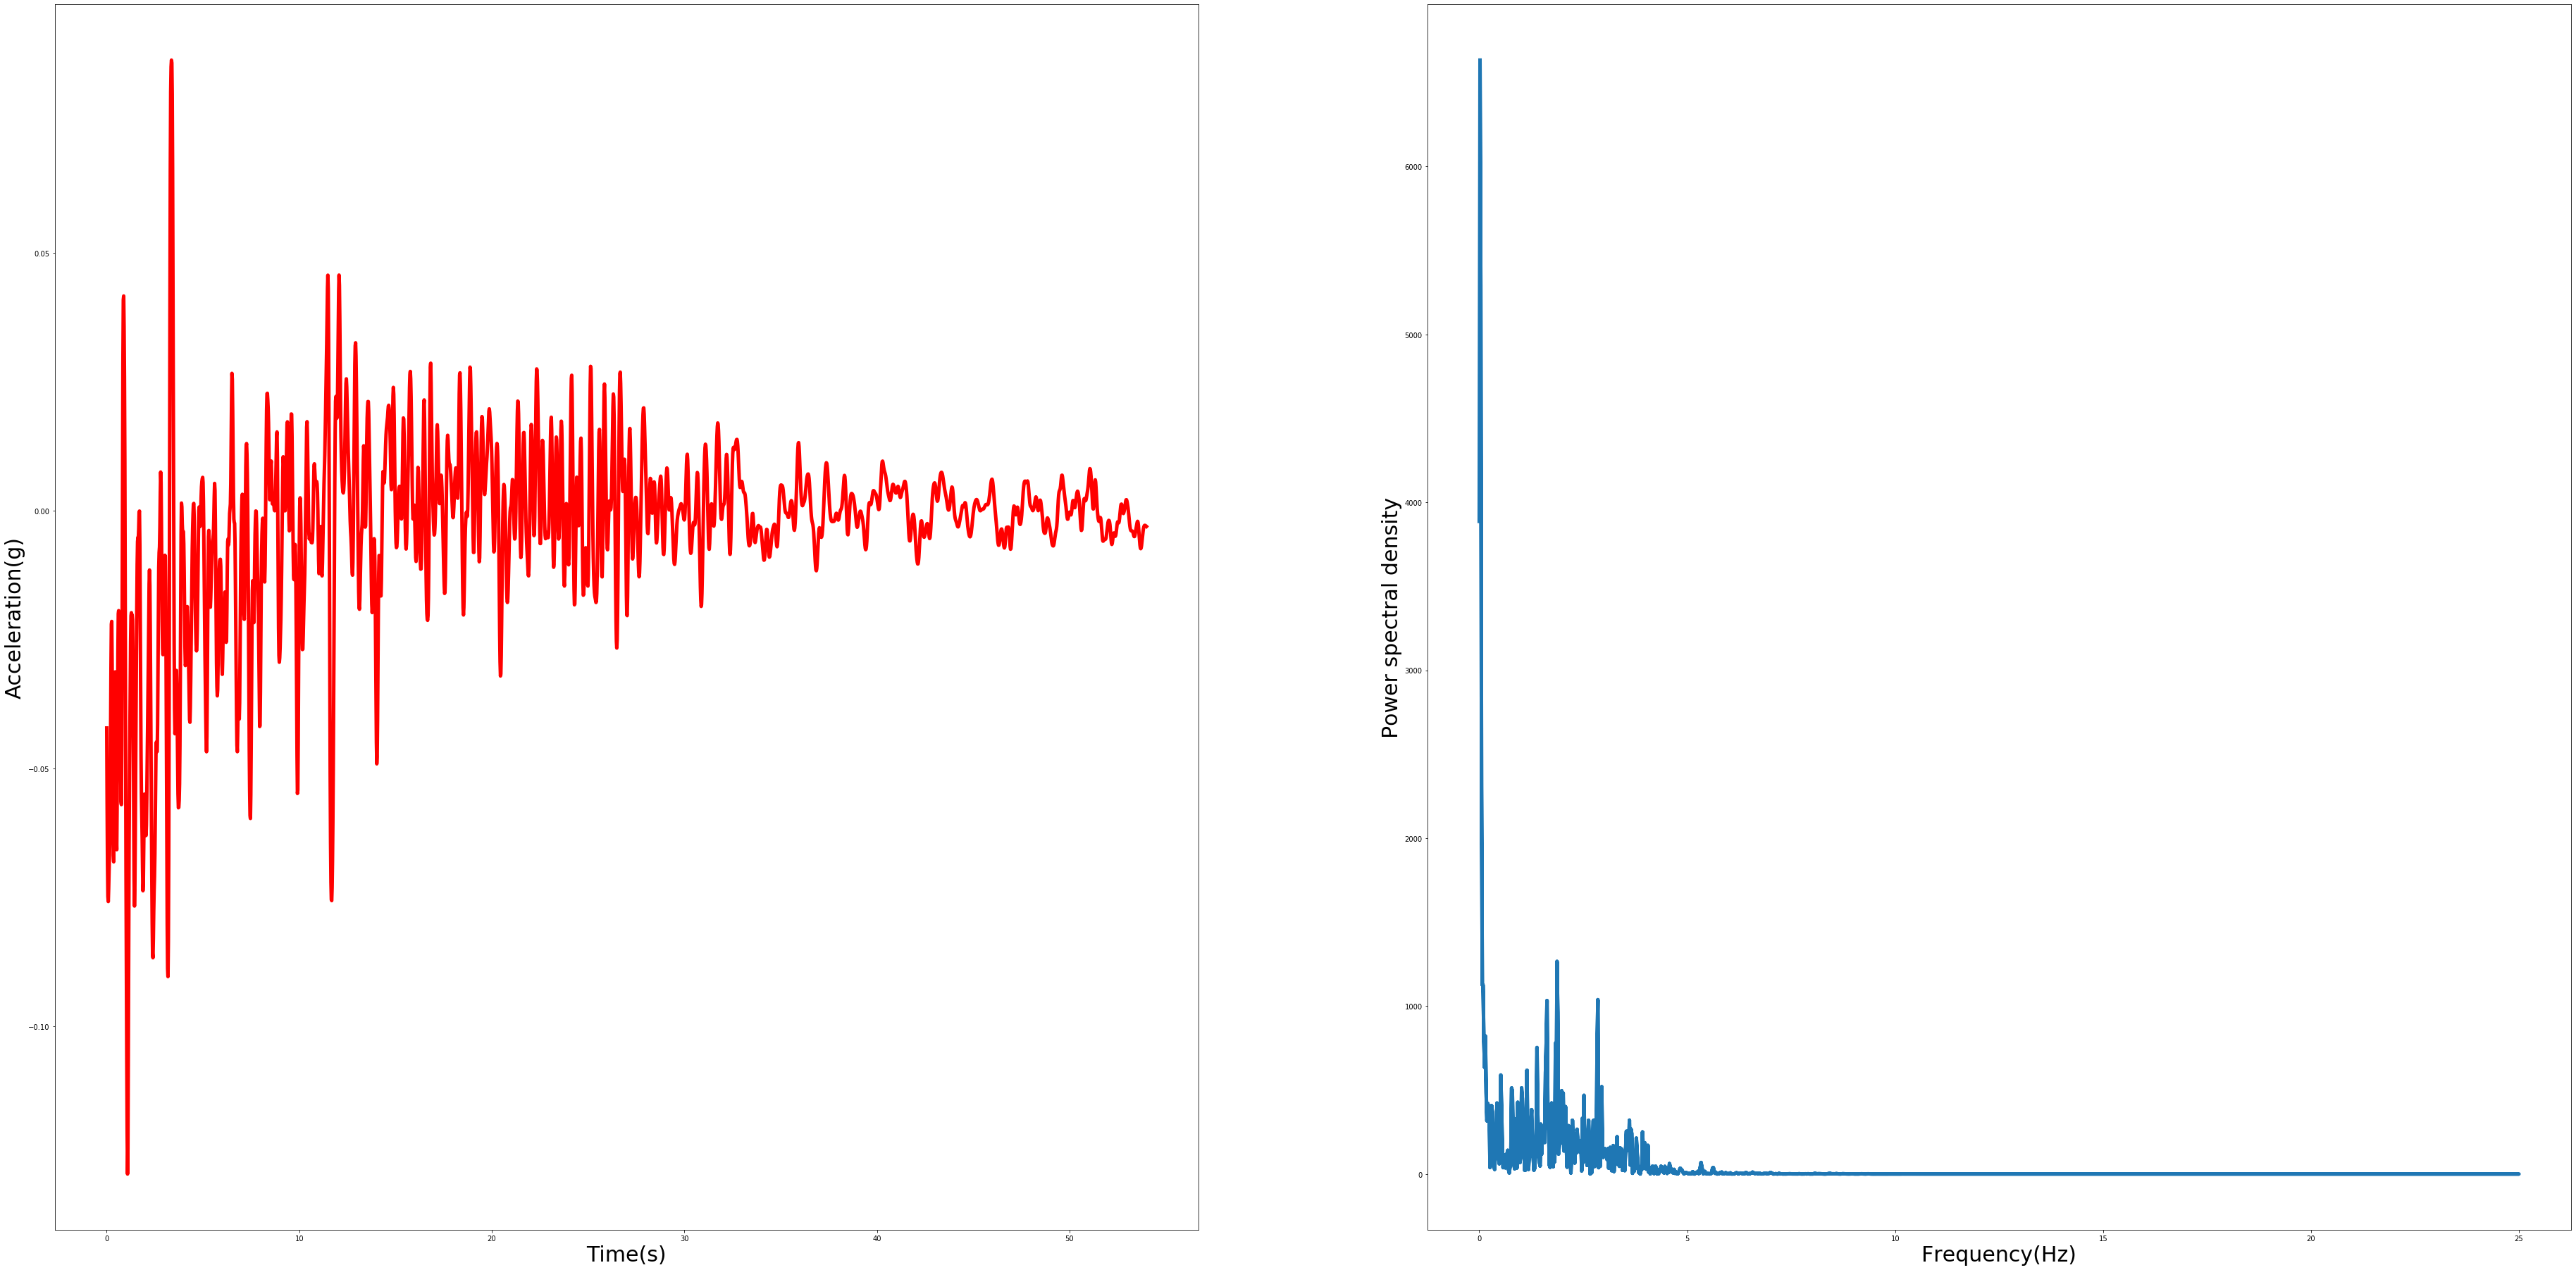

In [18]:
#Seismic waves in the interval 0.03 to 4 Hz
for i in range(3):
    plot_filtered_seismogram(Input[i],0.03,4,0.02,2)

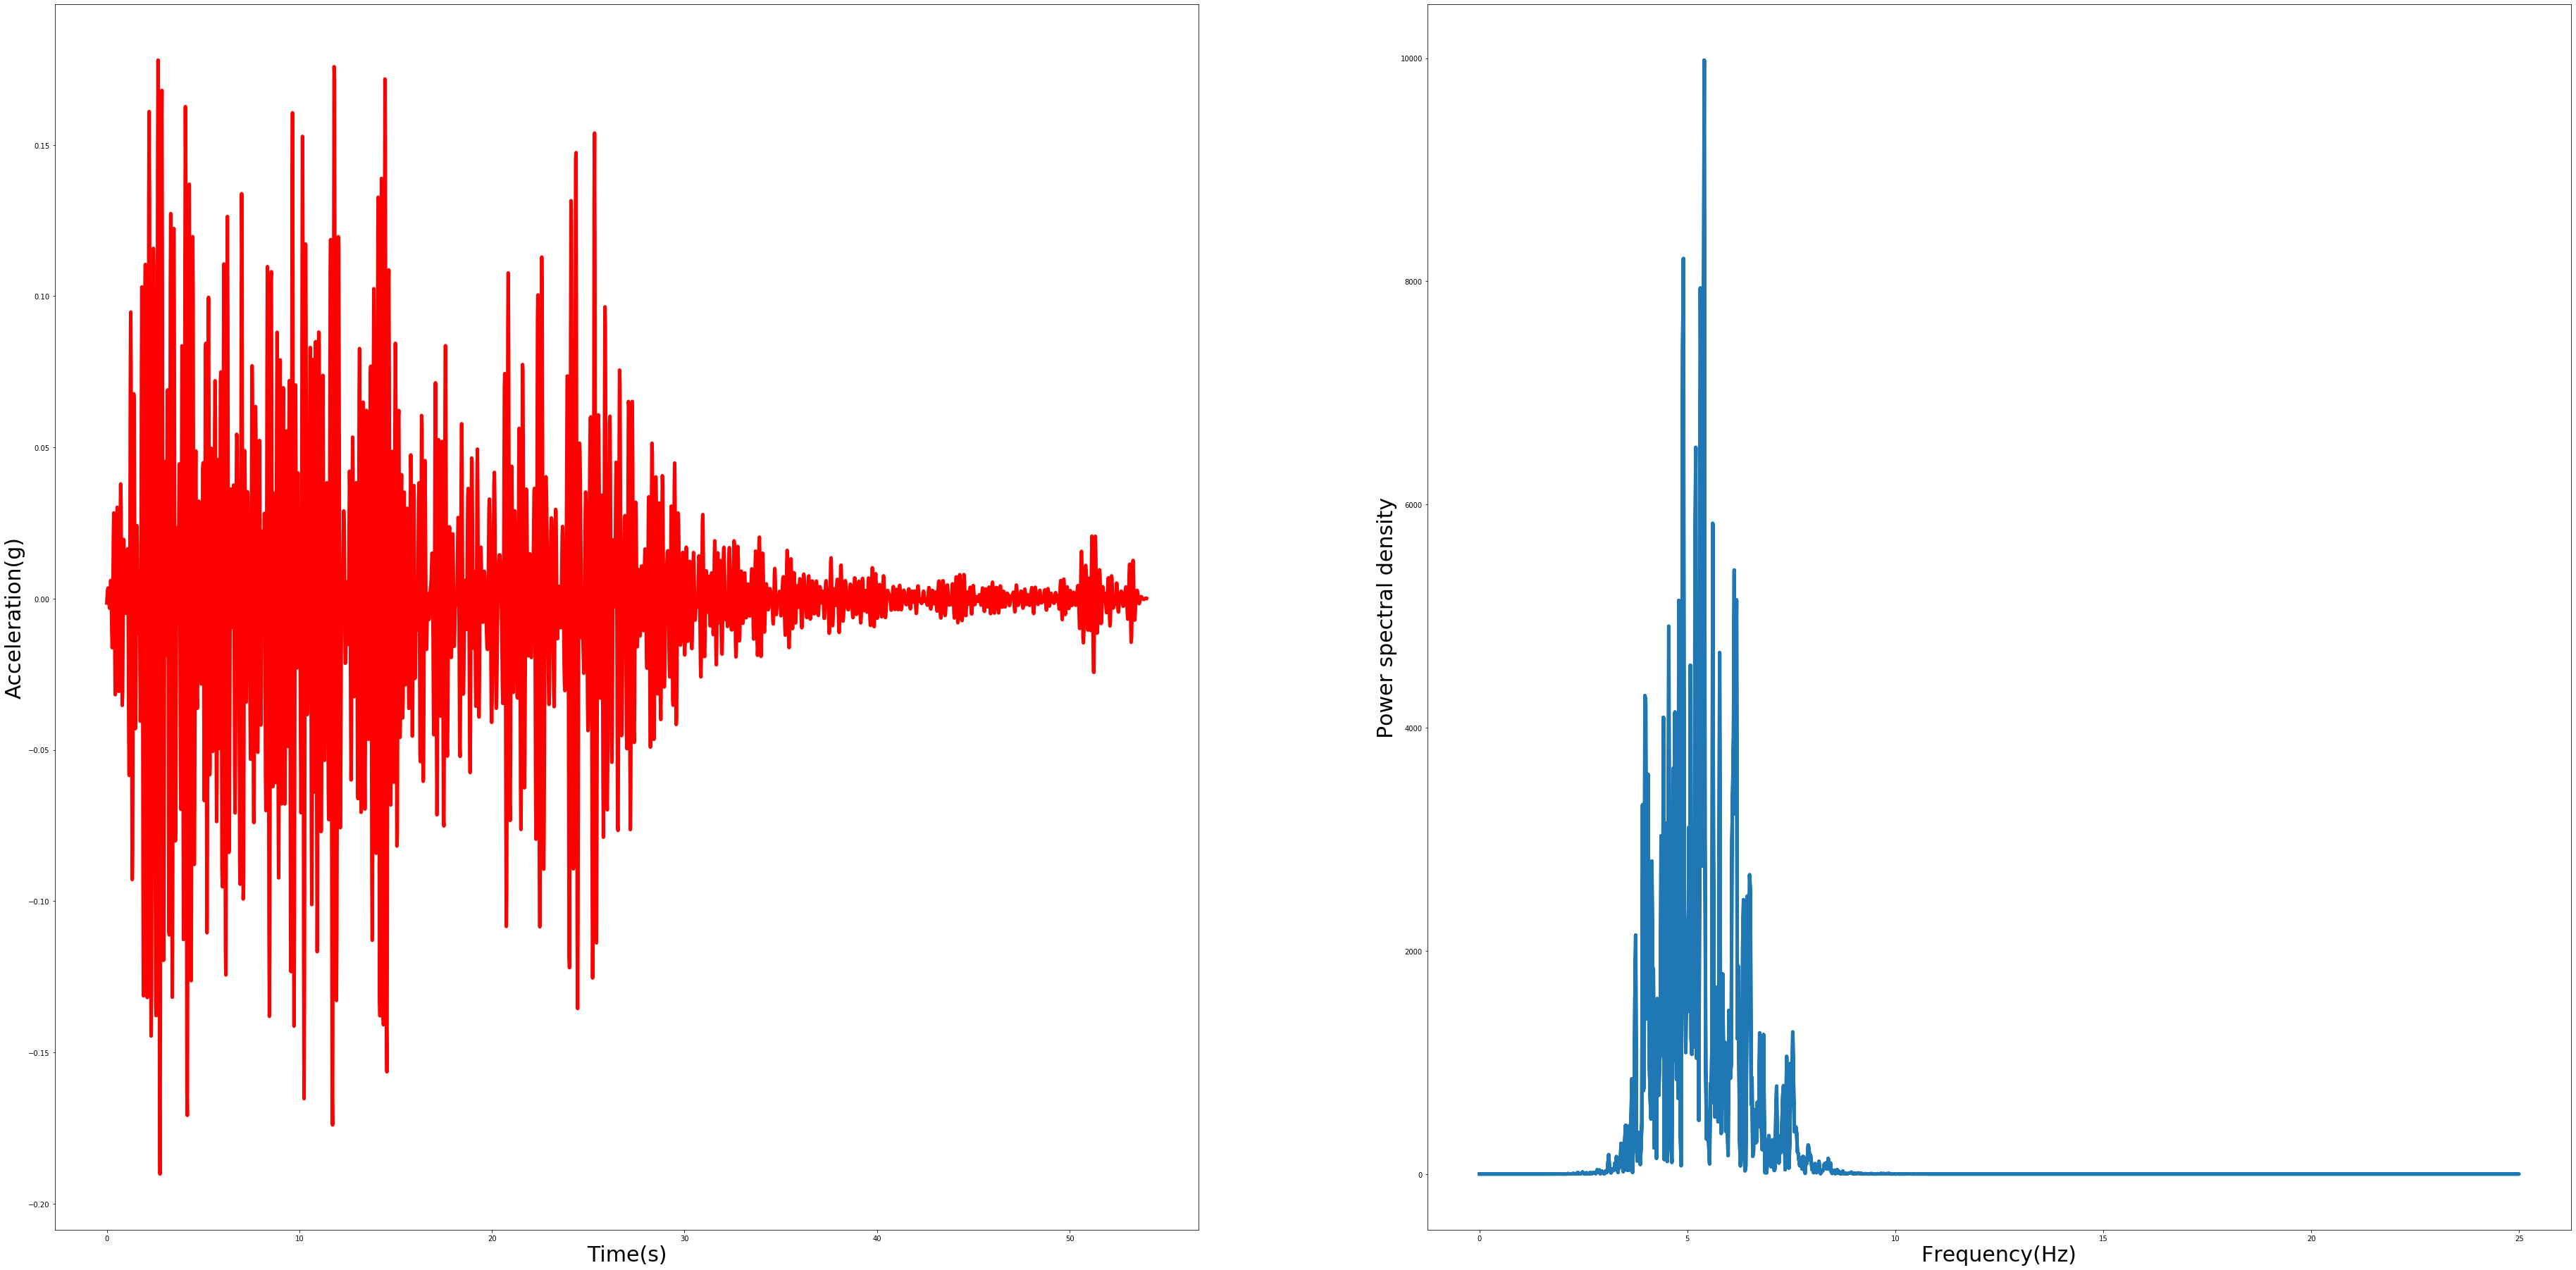

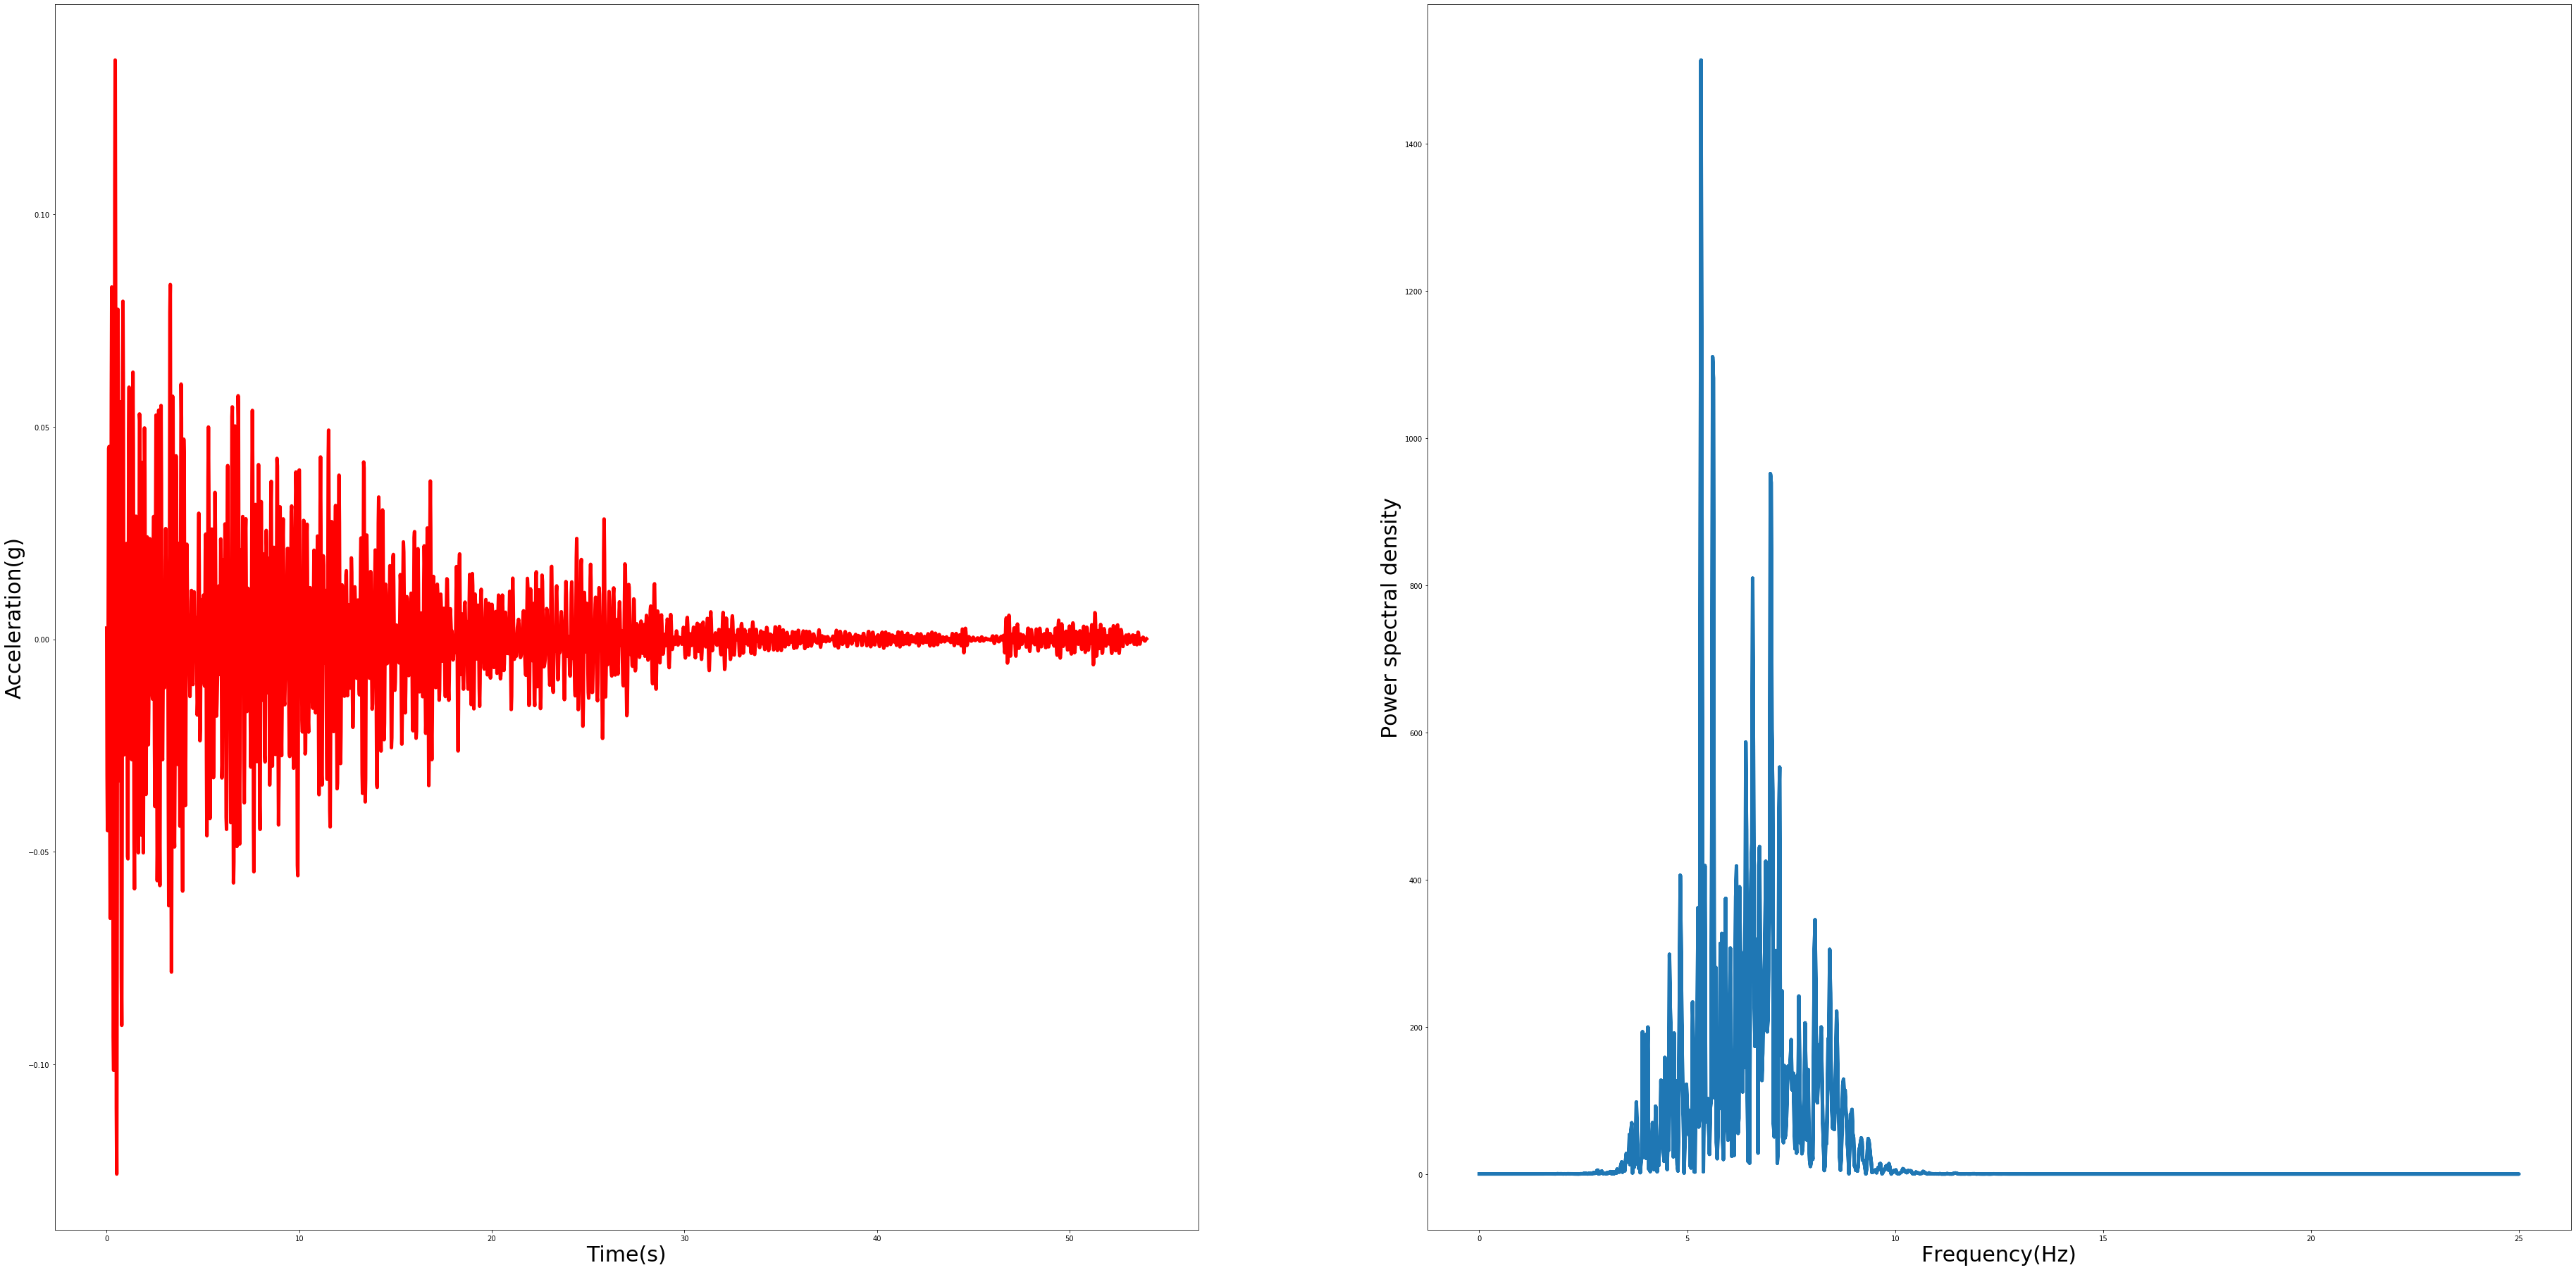

In [19]:
#Seismic waves in the interval 4 to 8 Hz
for i in range(3):
    plot_filtered_seismogram(Input[i],4.01,8,0.02,2)

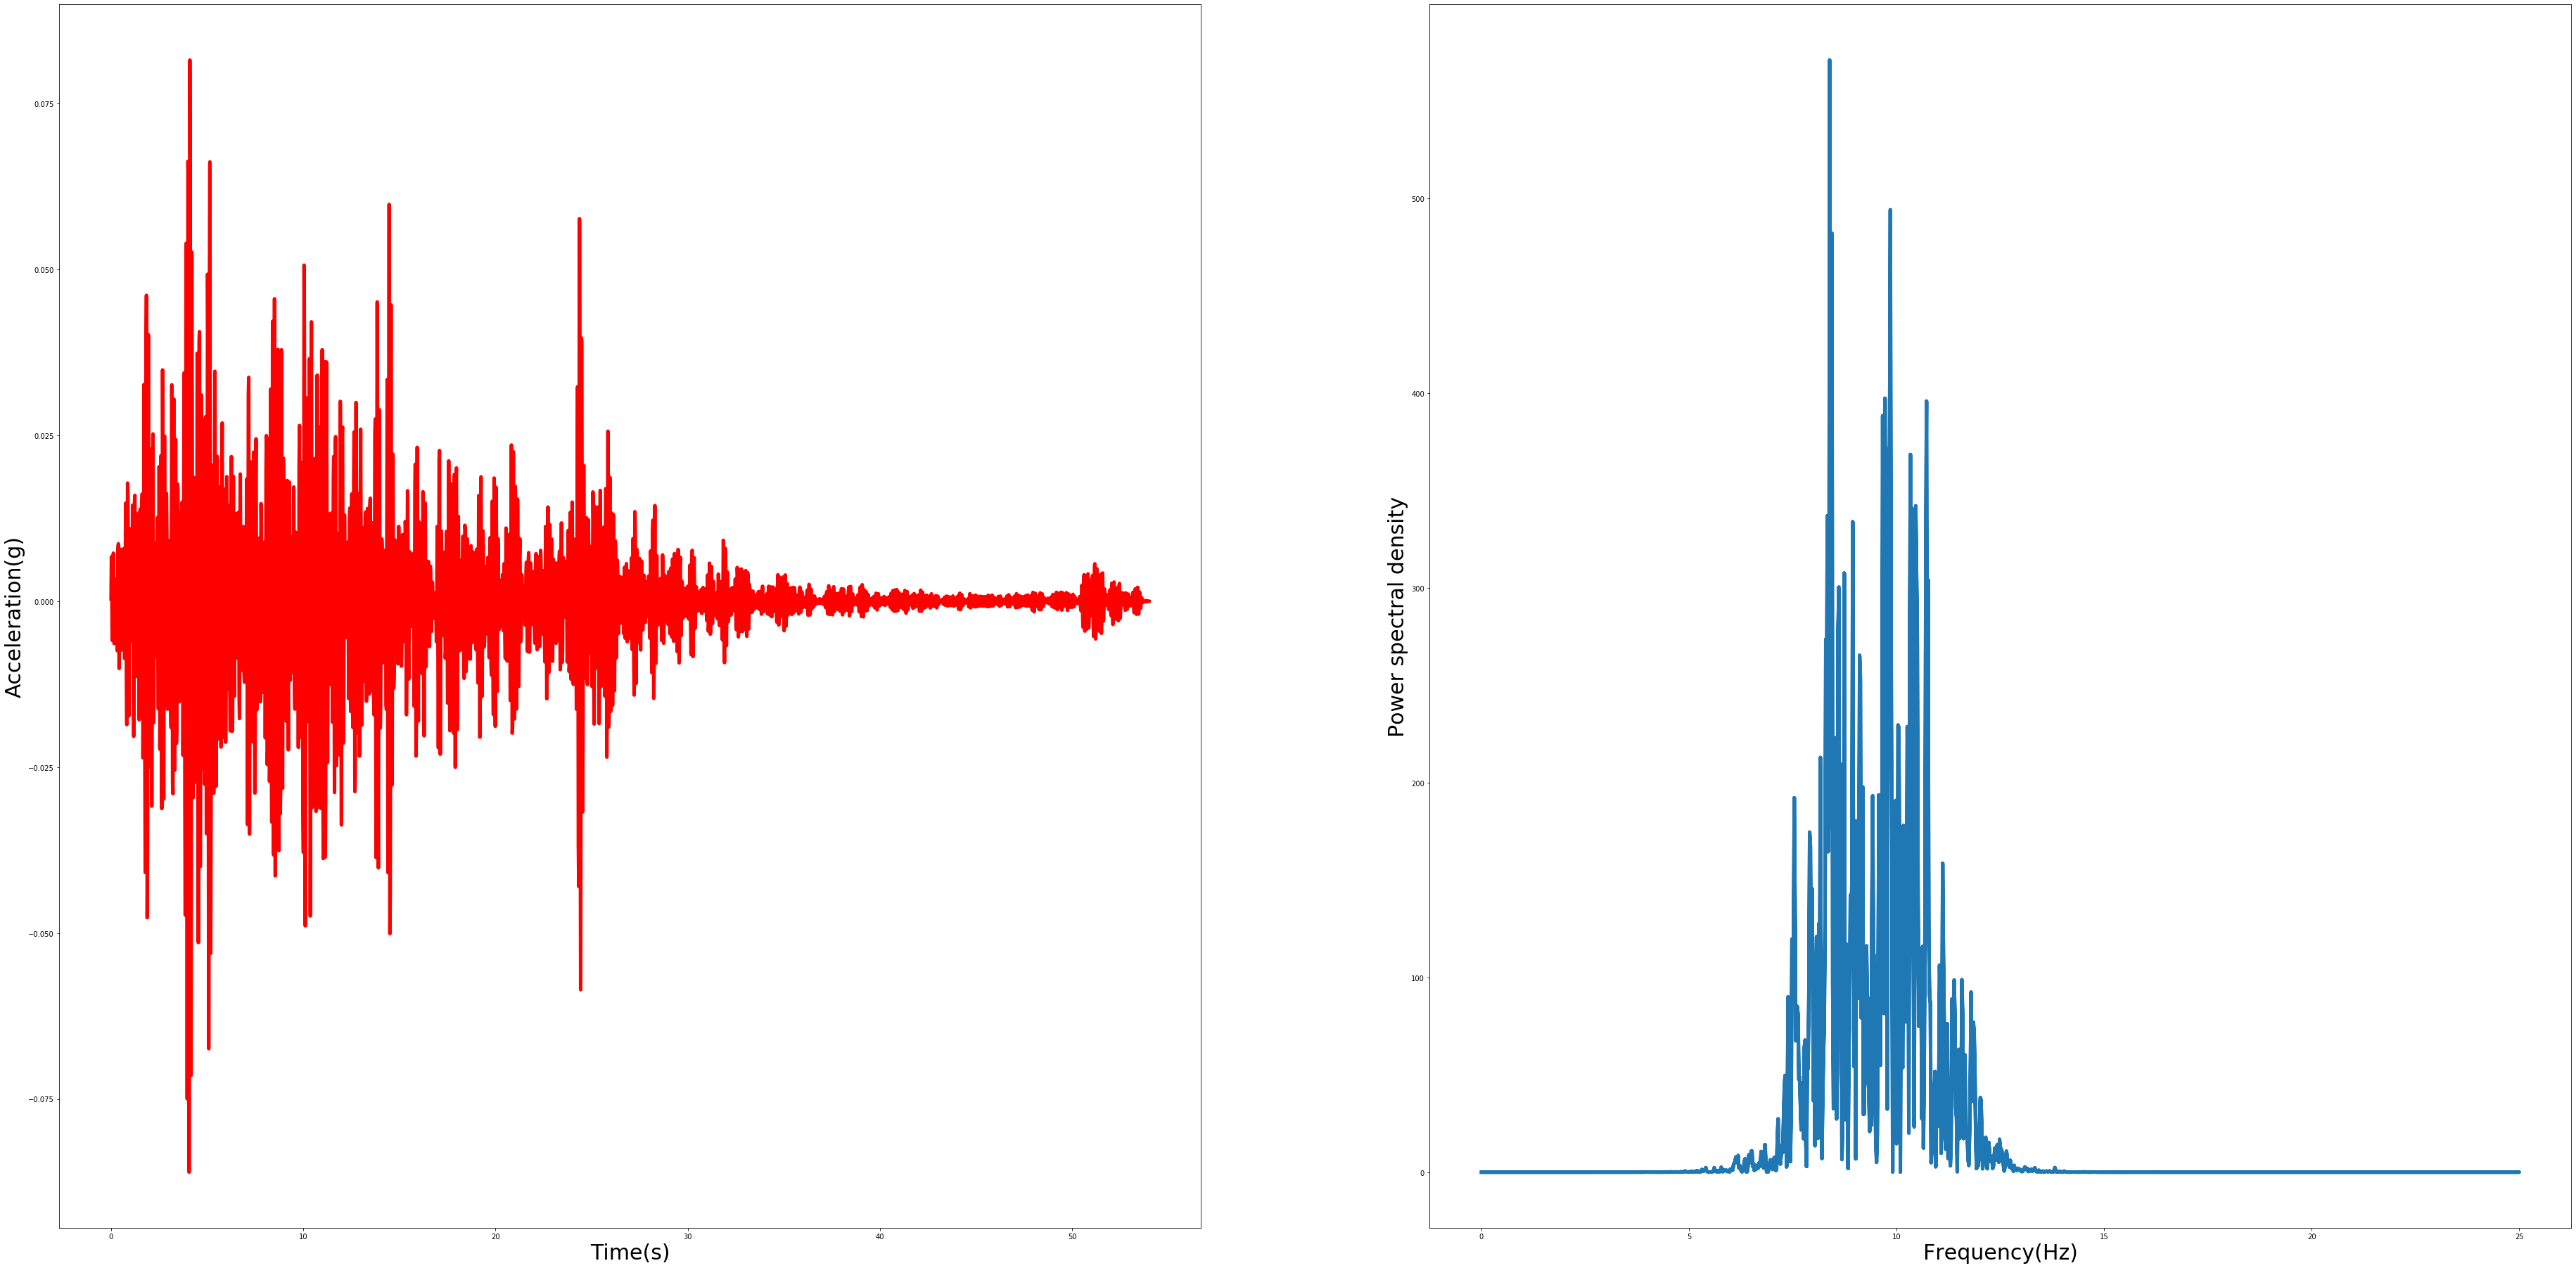

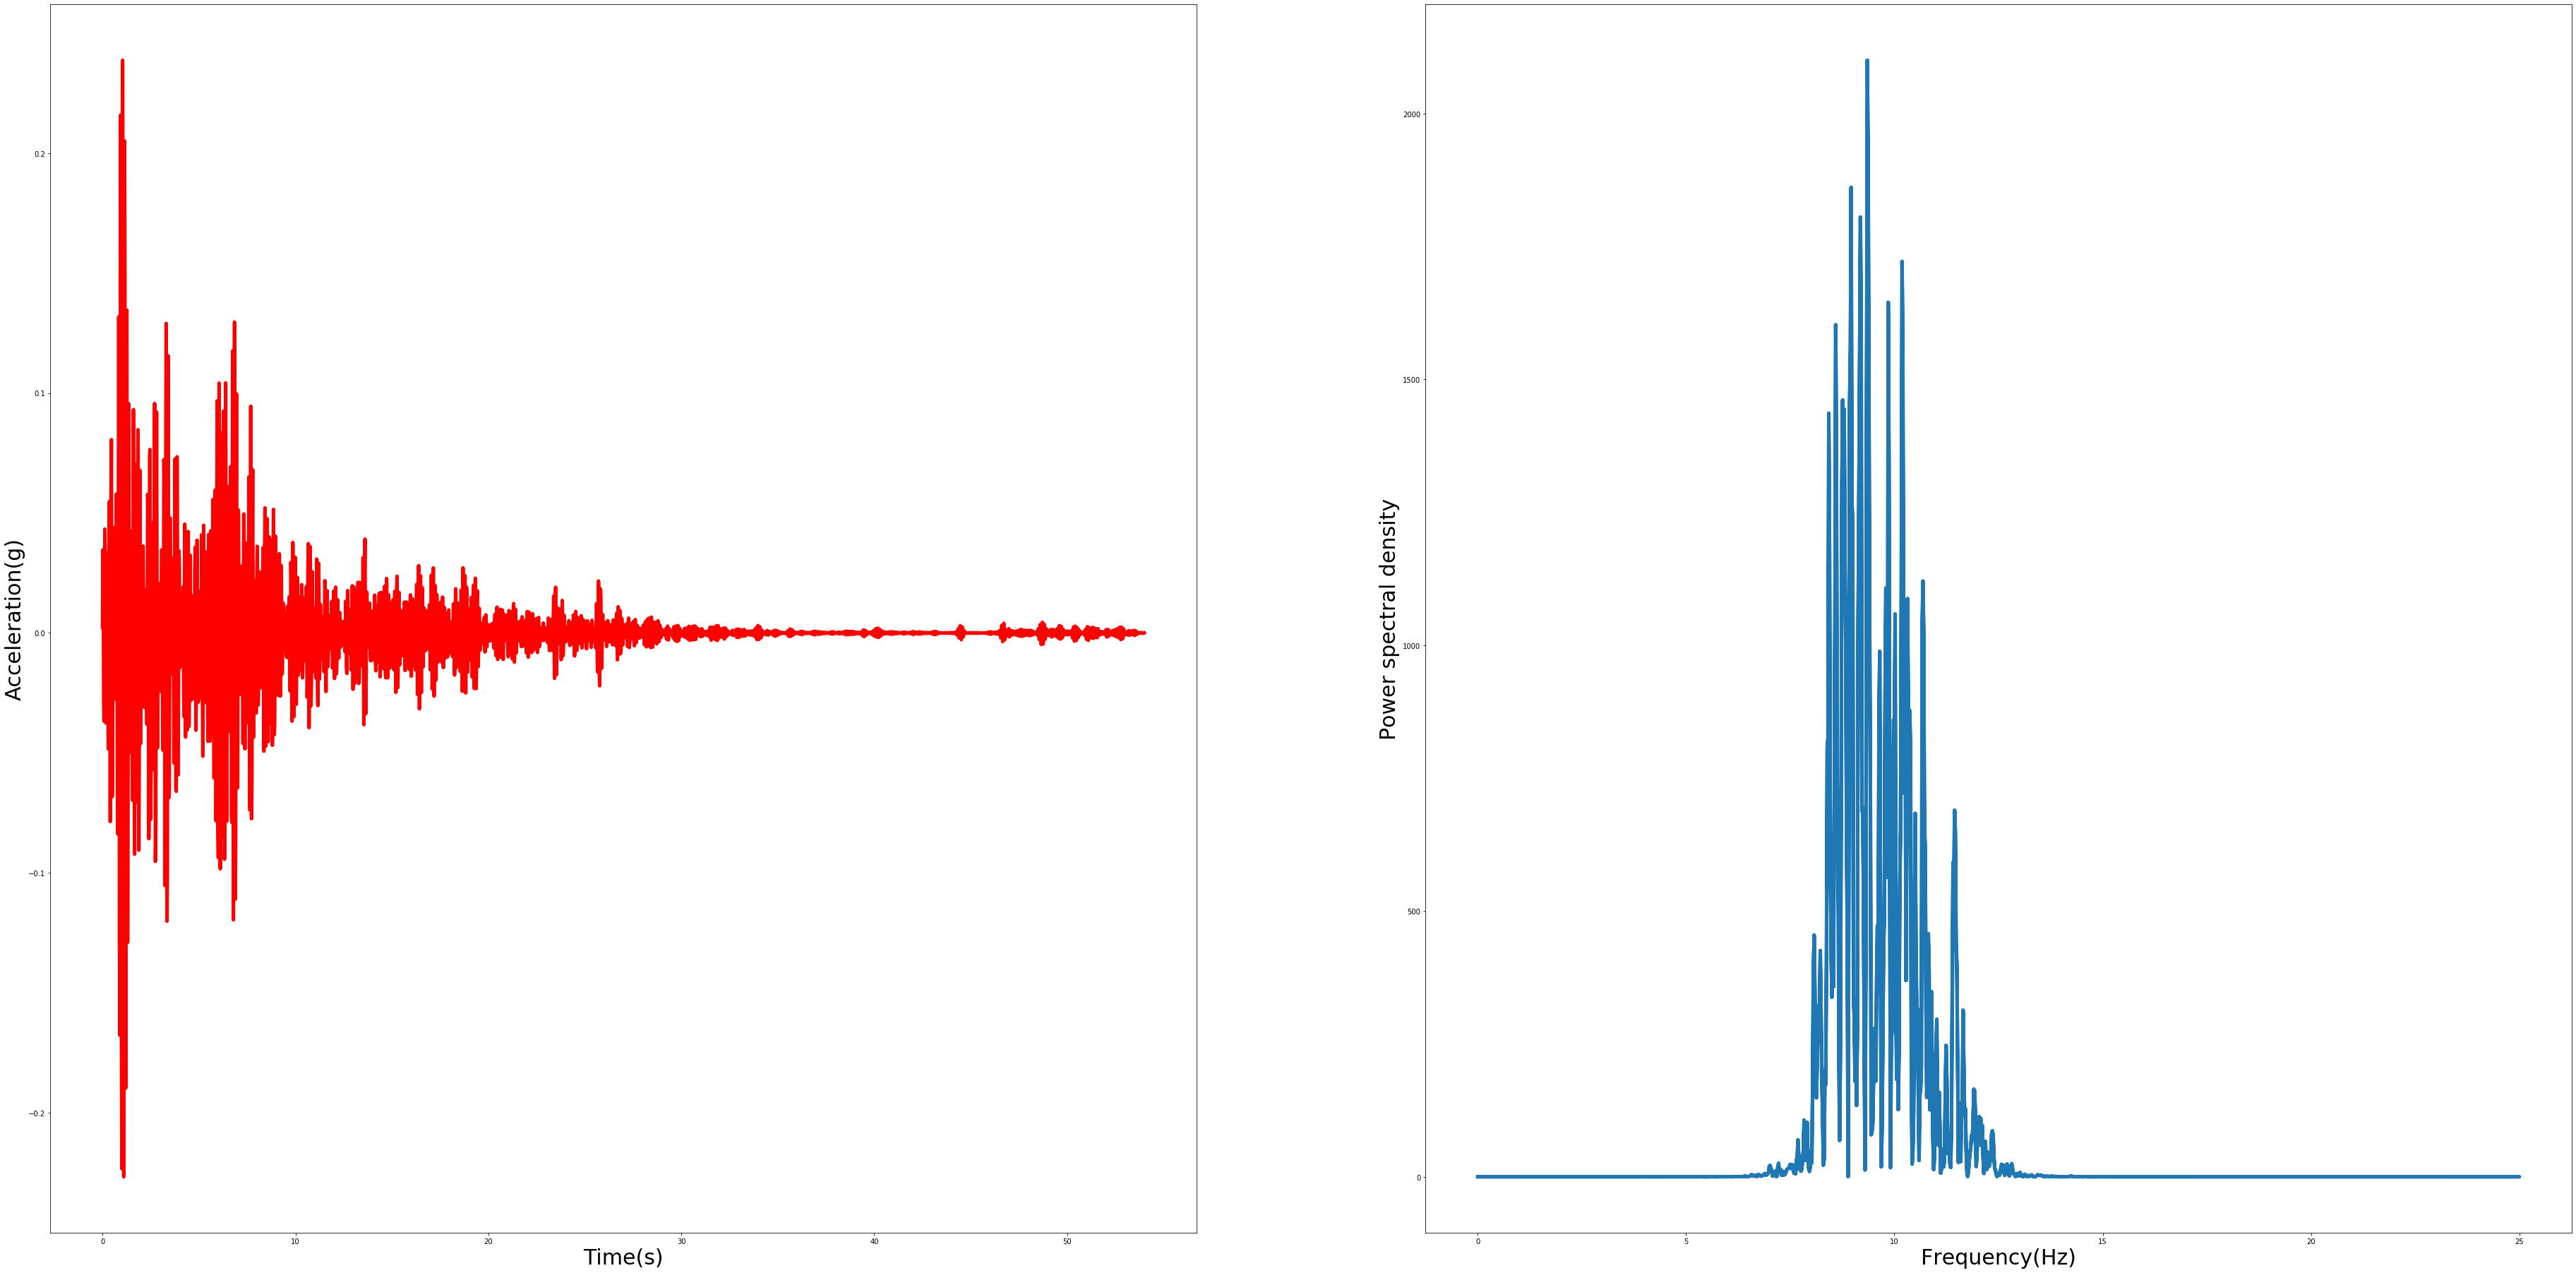

In [20]:
#Seismic waves in the interval 8 to 12 Hz
for i in range(3):
    plot_filtered_seismogram(Input[i],8.01,12.0,0.02,2)

From the observation of above graphs it appears as if reason second is correct, If it is correct let us proceed with that.

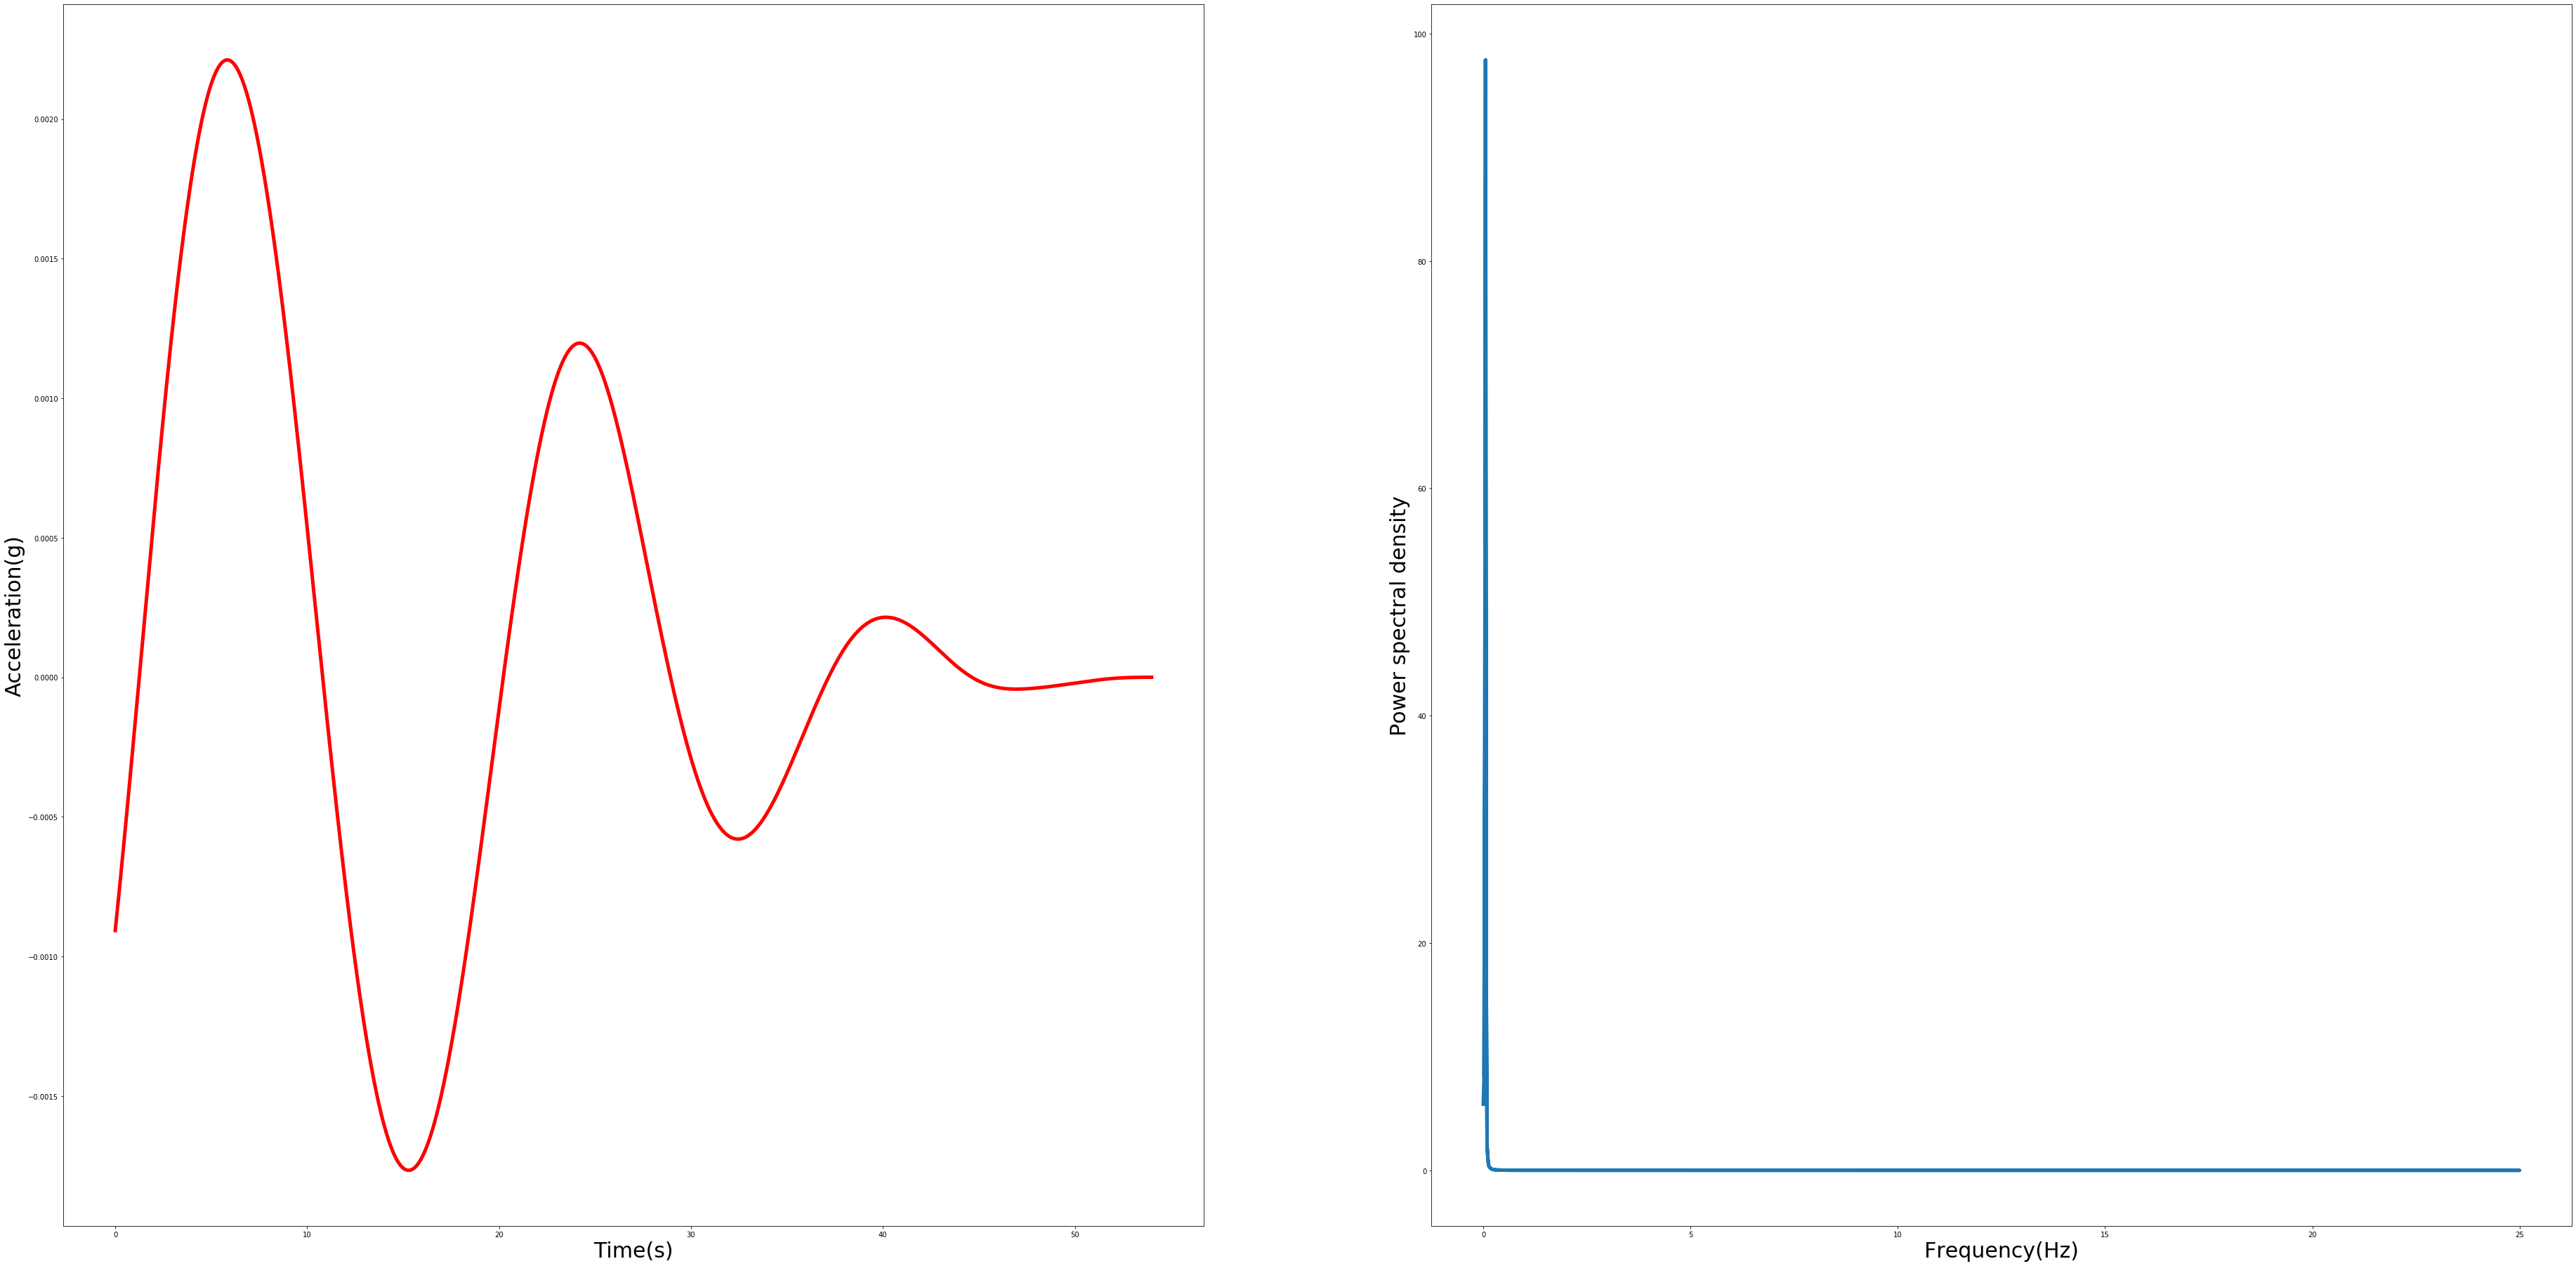

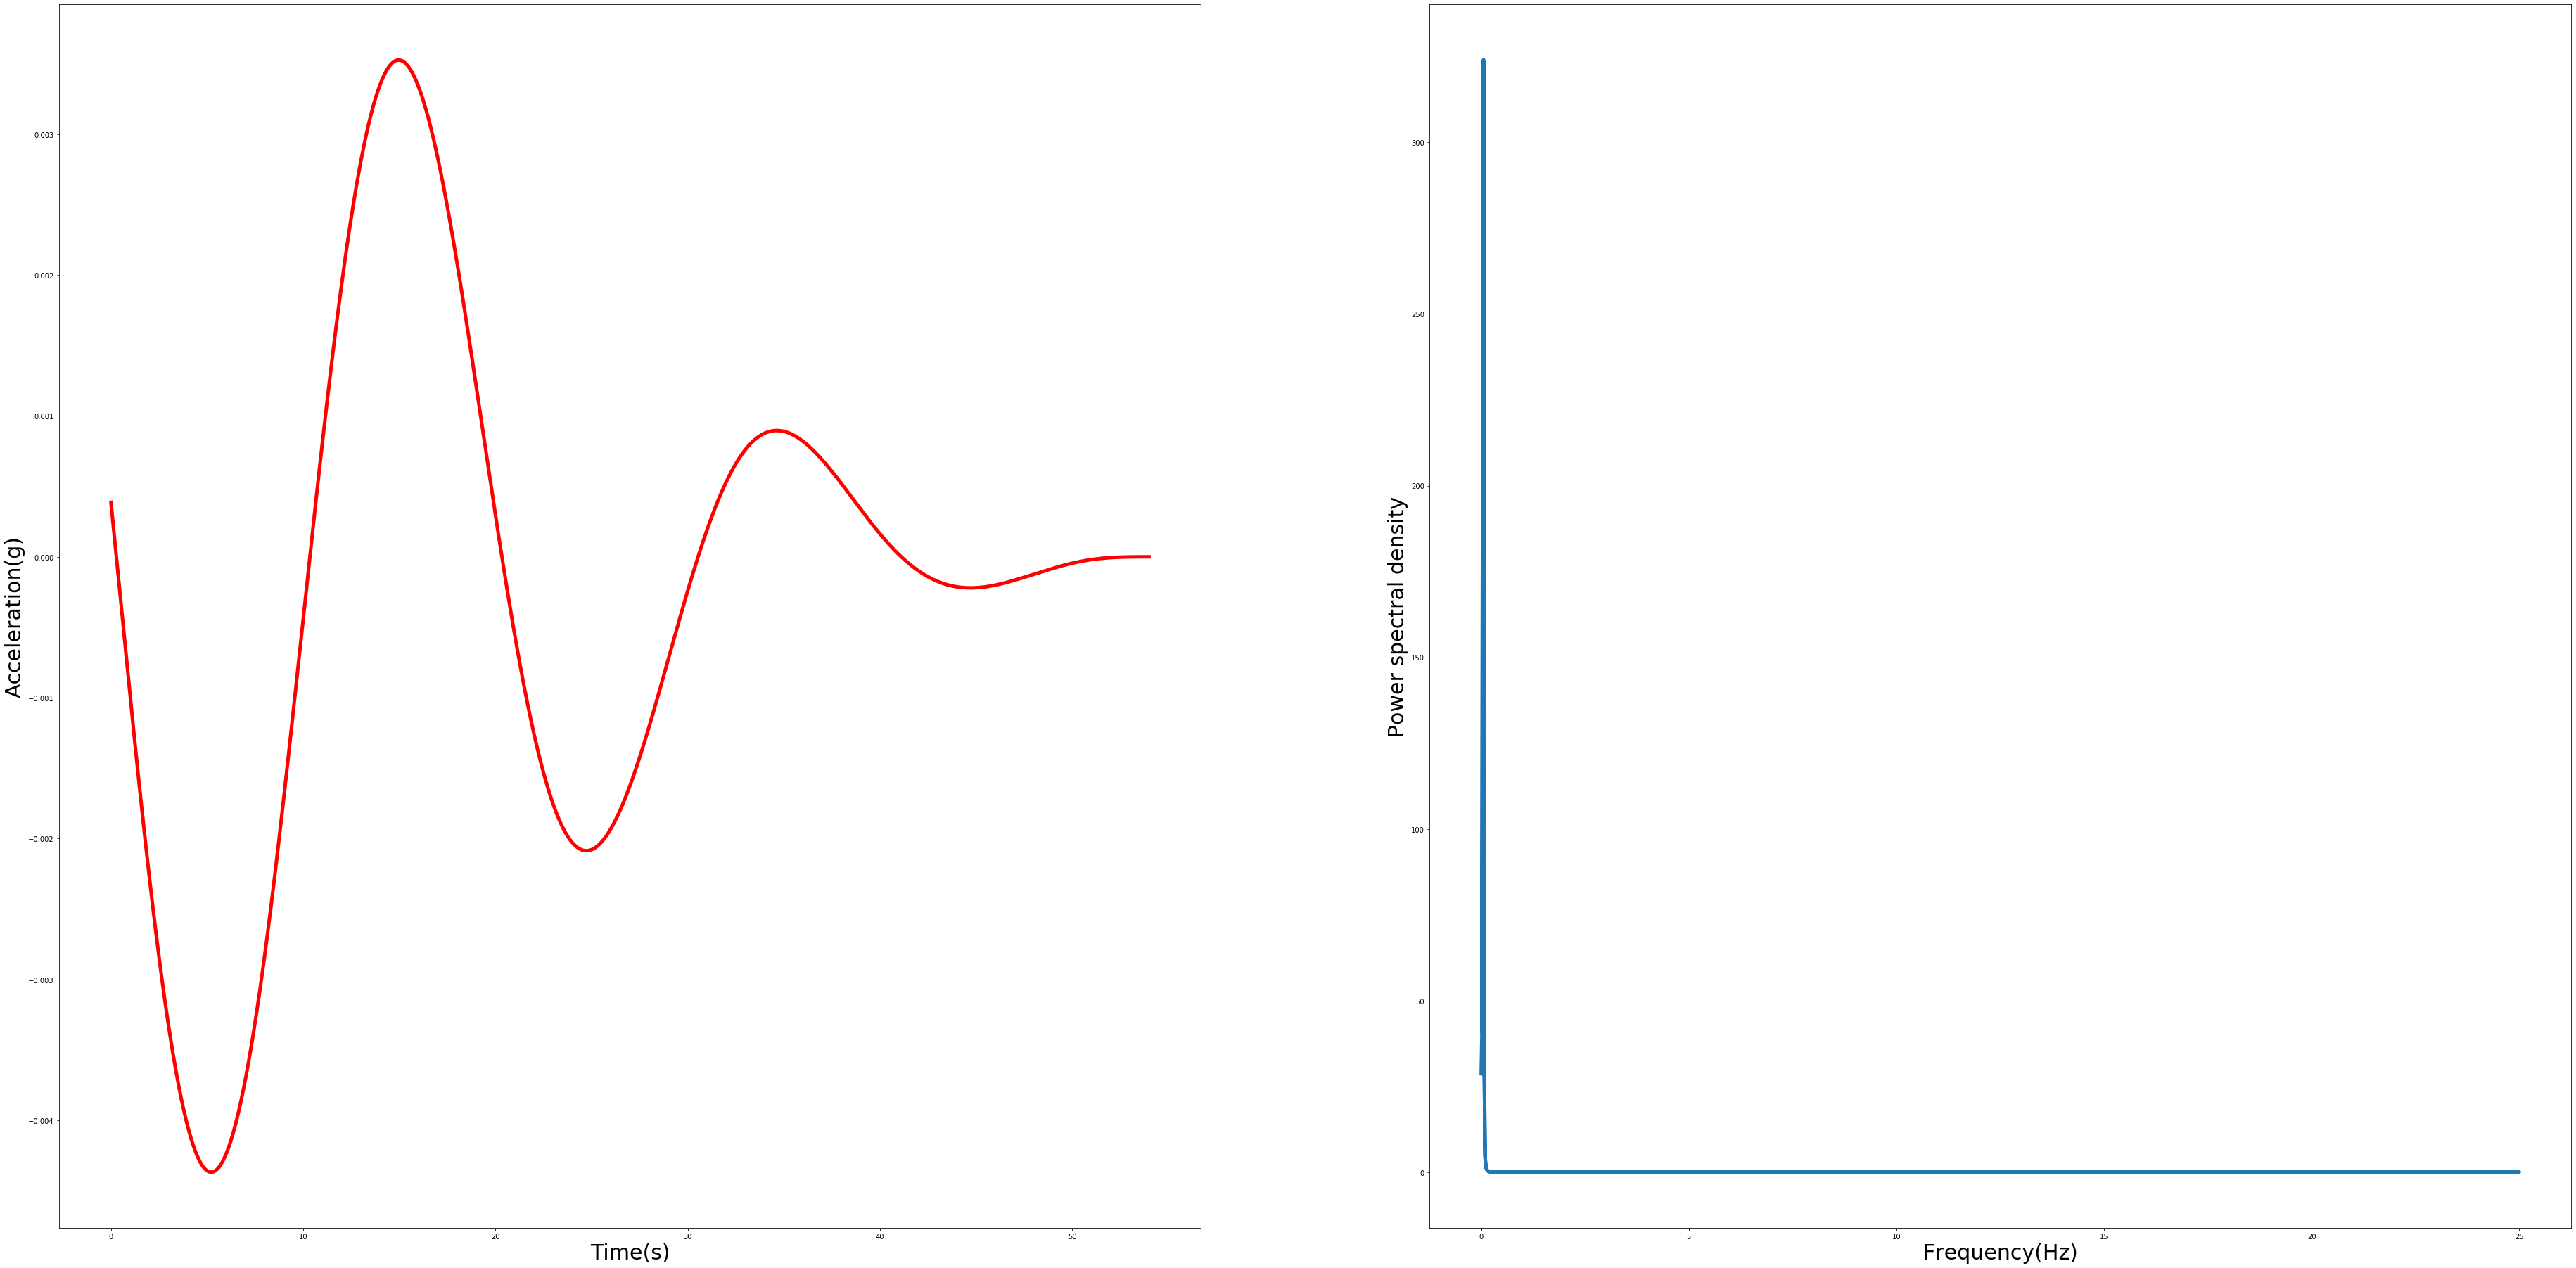

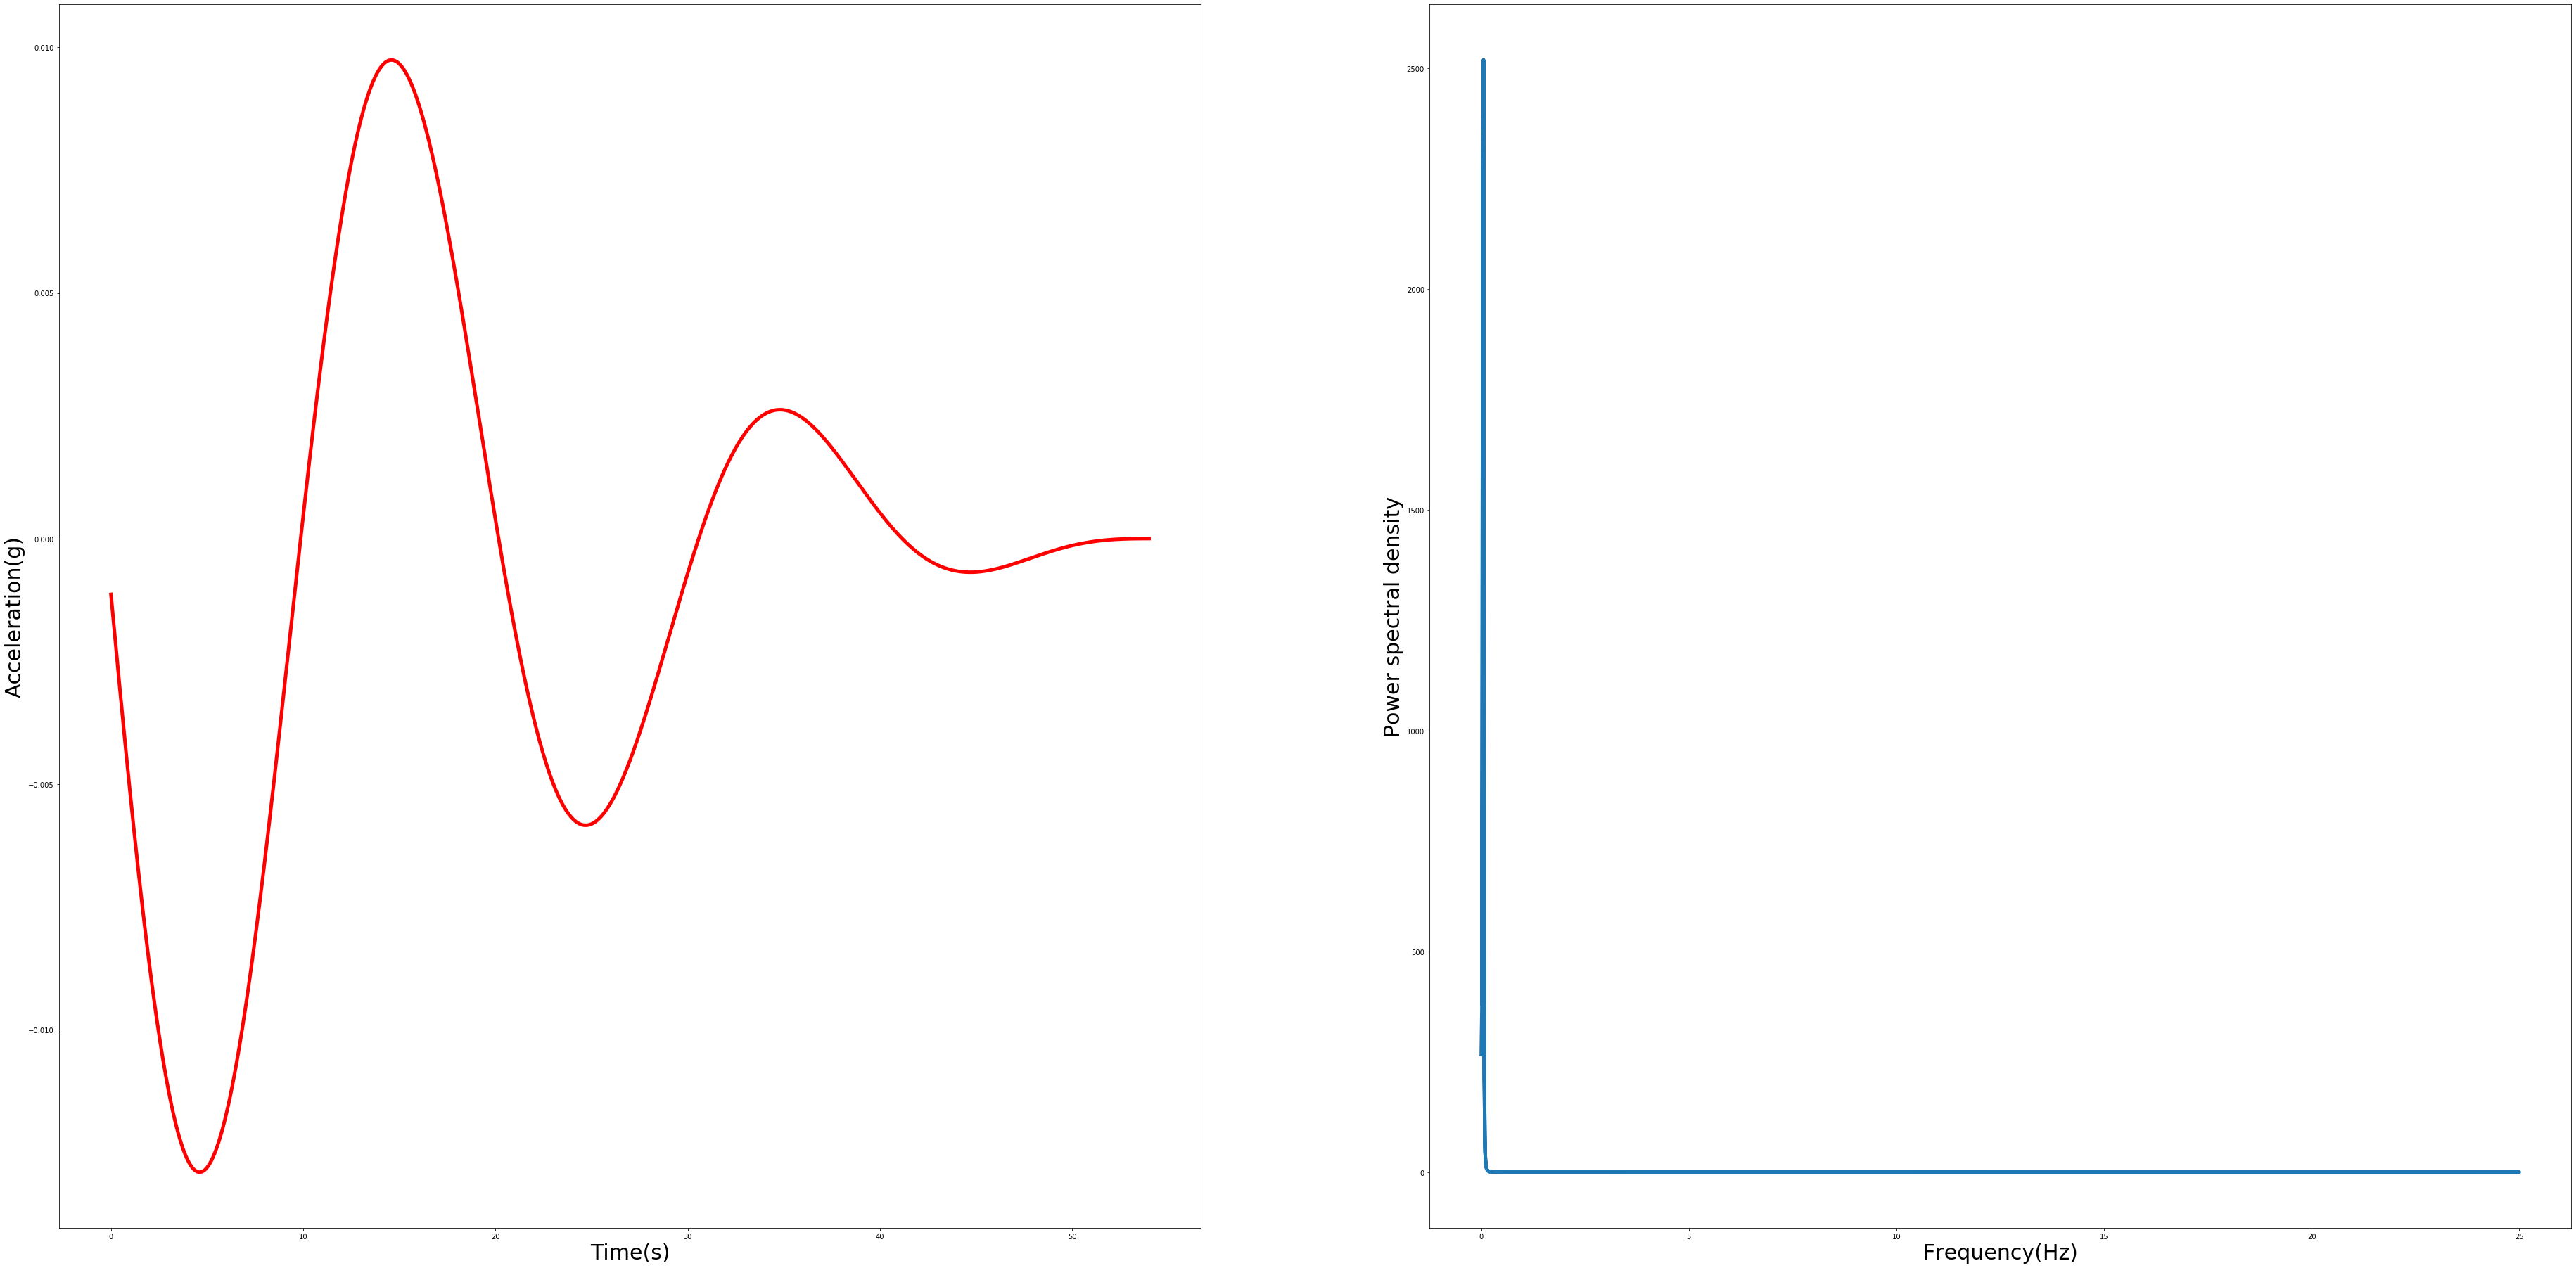

In [21]:
#plotting seismographs for 0.04 t0 0.06 Hz

for i in range(3):
    plot_filtered_seismogram(Input[i],0.04,0.06,0.02,2)

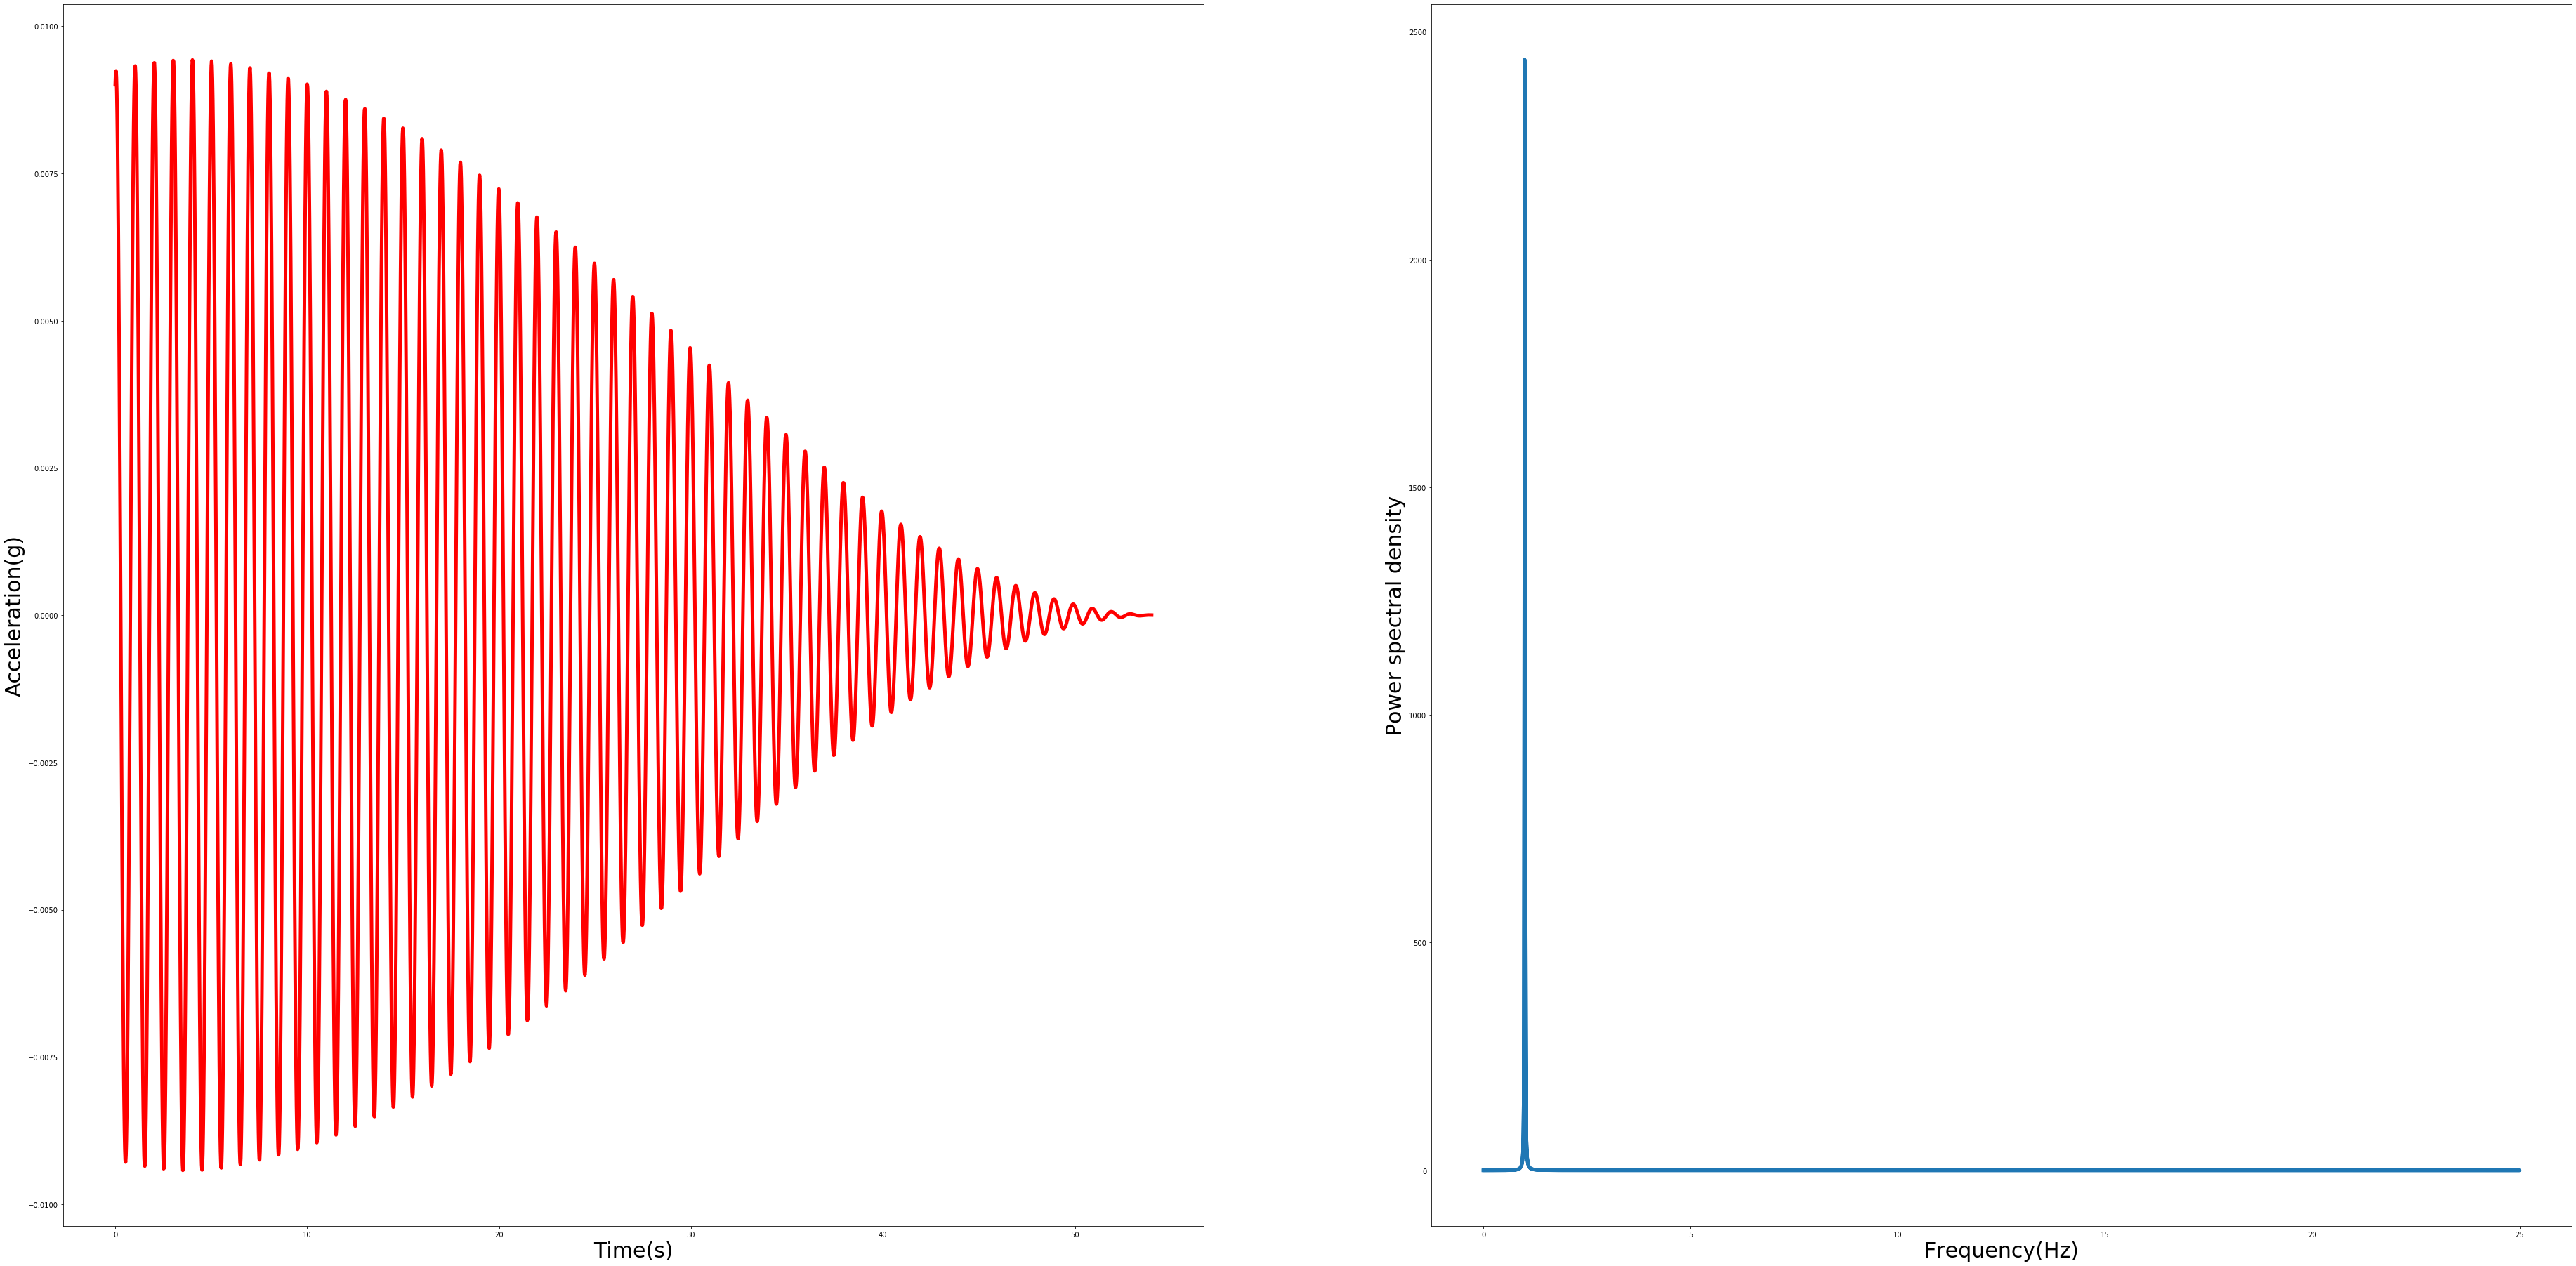

In [22]:
#plotting seismographs for 0.99 t0 1.01 Hz

for i in range(3):
    plot_filtered_seismogram(Input[i],0.99,1.01,0.02,2)

According to a book here.https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=14&ved=2ahUKEwj-xZ_J5NHoAhWzyDgGHS34BEIQFjANegQIAhAB&url=https%3A%2F%2Fgfzpublic.gfz-potsdam.de%2Frest%2Fitems%2Fitem_4009_4%2Fcomponent%2Ffile_4010%2Fcontent%3Fdownload%3Dtrue&usg=AOvVaw0LuFQtvg46RHsxo1gcZihA
The criteria for differentiation between earthquake and explosions is the ratio of the magnitude of P wave sampled at around 1Hz while surface waves sampled at 0.05Hz.(Explosions are like impacts atleast for seismographs)

In [23]:
butter_filter=butter(2,(0.04/25,0.06/25),btype='bandpass')

#Calculating the resultant magnitude by addition of all three components.(squaring and adding)

Magnitude_Swave=np.sqrt(8/3)*np.sqrt(filtfilt(butter_filter[0],butter_filter[1],a1)**2+np.sqrt(8/3)*filtfilt(butter_filter[0],butter_filter[1],a2)**2+np.sqrt(8/3)*filtfilt(butter_filter[0],butter_filter[1],a3)**2)
Mean_S=np.mean(Magnitude_Swave)

In [24]:
butter_filter=butter(2,(0.99/25,1.01/25),btype='bandpass')

#Calculating the resultant magnitude by addition of all three components.(squaring and adding)

Magnitude_Pwave=np.sqrt(8/3)*np.sqrt(filtfilt(butter_filter[0],butter_filter[1],a1)**2+np.sqrt(8/3)*filtfilt(butter_filter[0],butter_filter[1],a2)**2+np.sqrt(8/3)*filtfilt(butter_filter[0],butter_filter[1],a3)**2)
Mean_p=np.mean(Magnitude_Pwave)

In [25]:
Ratio=Mean_S/Mean_p
print(Ratio)
if Ratio>1.3:#criteria picked from paper
    print('Probably Earthquake')
else:
    print('Probably Impact')

1.5743832519640393
Probably Earthquake


In [29]:
#This block of code was written to check seismographs at every 1.25 Hz interval. This code works but takes a lot of time to implement , so This may be used only for finer analysis.

'''for k in range(int(1/0.05)):
    butter_filter=butter(2,(k*0.05+0.001,(k*0.05+0.0499)),btype='bandpass')
    output=list()
    output.append(np.sqrt(8/3)*filtfilt(butter_filter[0],butter_filter[1],a1))
    output.append(np.sqrt(8/3)*filtfilt(butter_filter[0],butter_filter[1],a2))
    output.append(np.sqrt(8/3)*filtfilt(butter_filter[0],butter_filter[1],a3))
    np.size(output[0])
    plt.figure(figsize=(128,96))
    for i in range(int(np.size(output)/np.size(output[0]))):
        t=np.linspace(0,54,np.size(output[i]))
        plt.subplot(np.size(output)/np.size(output[0]), 2, 2*i+1)
        plt.plot(t,output[i],linewidth=5,color='r')
        ffta=np.fft.fft(output[i])
        fftfreq=np.fft.fftfreq(np.size(output[i]),0.02)
        Power_spectral=(ffta*np.conjugate(ffta))*54#power spectral density=amplitude^2/delta f where delta f=1/T where T=total time the  signal last
        plt.subplot(np.size(output)/np.size(output[i]),2,2*(i+1))
        plt.plot(abs(fftfreq),Power_spectral,linewidth=5)''';

In [27]:
'''Interactive widgets for selecting frequency region to be filtered'''

def butter_filt(l,h,n):
    butter_filter=butter(n,(l,h),btype='bandpass',)
    output=np.sqrt(8/3)*filtfilt(butter_filter[0],butter_filter[1],a1)
    t=np.arange(0,np.size(a1)*0.02,0.02)
    plt.plot(t,output)

In [28]:
from ipywidgets import interact, IntSlider, FloatSlider
interact(butter_filt,l=FloatSlider(min=0.001,max=0.999,step=0.001,value=0.000),h=FloatSlider(min=0.001,max=0.999,step=0.001,value=0.100),n=IntSlider(min=1,max=6,value=2))

interactive(children=(FloatSlider(value=0.001, description='l', max=0.999, min=0.001, step=0.001), FloatSlider…

<function __main__.butter_filt(l, h, n)>